# Analysis of Bureau of Transportation Statistics on Utilization and Spending Trends

## Section Headings

This notebook will be divided into two sections, `GLM/NPM Prediction` and `Causality Analysis`, as found in the analysis write-up. *Note that all methods regarding each section will be found below each respective heading. This includes shared methods such as EDA, Feature Engineering, Result Discussion, etc.*

**Section 1**: Generalized Linear Model vs. Non Parametric Model Prediction

`Research Question A`: *Predicting "State and Local Government Construction Spending - Transportation" in 2019 using past infrastructure data (up to 2018) in the US.*

**Section 2**: Causality Analysis

`Research Question B`: *Does investment in infrastructure have an causal impact on the utilization of infrastructure in the US? Specifically, does the change in state and local spending on land passenger terminals have a causal effect on the number of passenger rail passenger miles, and if so is it a positive or negative effect?*

# 1. GLM and Non Parametric Model Prediction

**Prompt**: (Comparing GLMs and nonparametric methods): Predicting "State and Local Government Construction Spending - Transportation" in 2019 using past infrastructure data (up to 2018) in the US.

## 1.1. GLM/NPM EDA

In [1]:
#Import Libraries and raw data
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma

import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import arviz

import warnings
warnings.filterwarnings('ignore')

raw = pd.read_csv("Monthly_Transportation_Statistics.csv")
raw.head()

,Index,Date,Air Safety - General Aviation Fatalities,Highway Fatalities Per 100 Million Vehicle Miles Traveled,Highway Fatalities,U.S. Airline Traffic - Total - Seasonally Adjusted,U.S. Airline Traffic - International - Seasonally Adjusted,U.S. Airline Traffic - Domestic - Seasonally Adjusted,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,...,Heavy truck sales SAAR (millions),U.S. Airline Traffic - Total - Non Seasonally Adjusted,Light truck sales SAAR (millions),U.S. Airline Traffic - International - Non Seasonally Adjusted,Auto sales SAAR (millions),U.S. Airline Traffic - Domestic - Non Seasonally Adjusted,Transborder - Total North American Freight,Transborder - U.S. - Mexico Freight,U.S. marketing air carriers on-time performance (percent),Transborder - U.S. - Canada Freight
0,0,01/01/1947 12:00:00 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,02/01/1947 12:00:00 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,03/01/1947 12:00:00 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,04/01/1947 12:00:00 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,05/01/1947 12:00:00 AM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
raw.columns, raw.shape

(Index(['Index', 'Date', 'Air Safety - General Aviation Fatalities',
        'Highway Fatalities Per 100 Million Vehicle Miles Traveled',
        'Highway Fatalities',
        'U.S. Airline Traffic - Total - Seasonally Adjusted',
        'U.S. Airline Traffic - International - Seasonally Adjusted',
        'U.S. Airline Traffic - Domestic - Seasonally Adjusted',
        'Transit Ridership - Other Transit Modes - Adjusted',
        'Transit Ridership - Fixed Route Bus - Adjusted',
        ...
        'Heavy truck sales SAAR (millions)',
        'U.S. Airline Traffic - Total - Non Seasonally Adjusted',
        'Light truck sales SAAR (millions)',
        'U.S. Airline Traffic - International - Non Seasonally Adjusted',
        'Auto sales SAAR (millions)',
        'U.S. Airline Traffic - Domestic - Non Seasonally Adjusted',
        'Transborder - Total North American Freight',
        'Transborder - U.S. - Mexico Freight',
        'U.S. marketing air carriers on-time performance (percent

### 1.1.1. Determine a start date to subset the raw data

In [3]:
#First and last date of data (regardless of nulls)
raw["Date"][0], list(raw["Date"])[-1]

('01/01/1947 12:00:00 AM', '11/01/2021 12:00:00 AM')

In [4]:
#Eliminate time to only include MM/YYYY since dd is always 1

raw["Month"] = [date[:3]+date[6:10] for date in raw["Date"]]

In [5]:
#Calculate the percentage of values in a row that are null 
raw["pct_null"] = list(raw.isnull().sum(axis=1) / len(raw.columns))

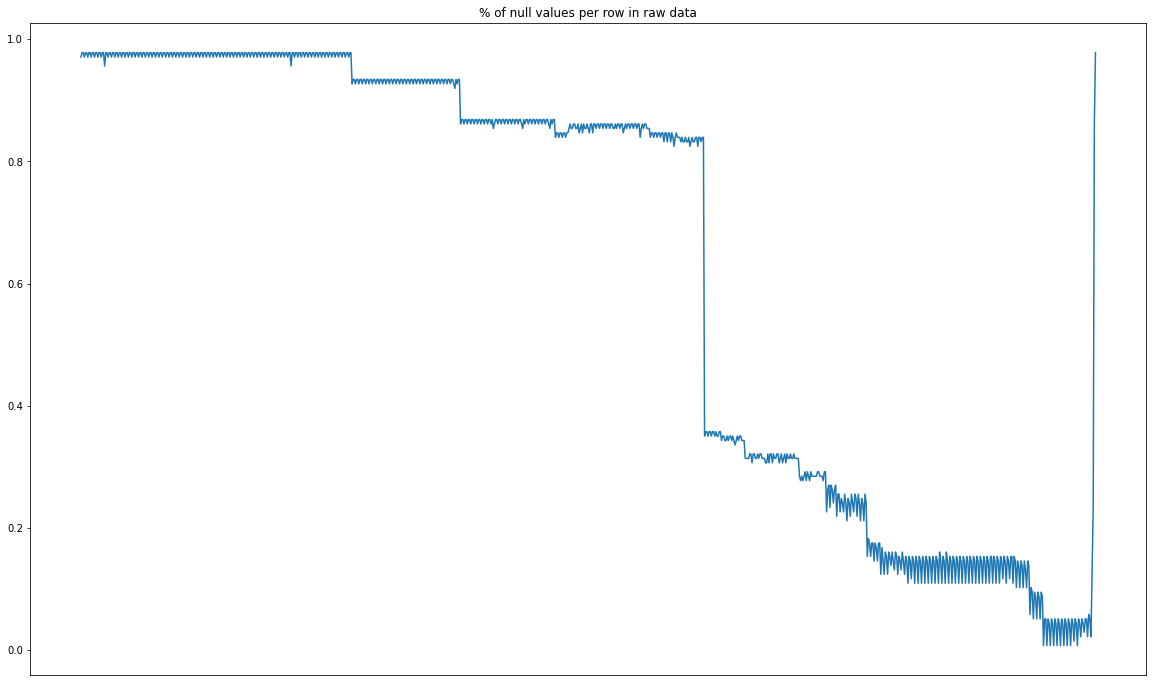

In [6]:
#Visualize pct of null values in each row vs. month
plt.figure(figsize=(20,12))
plt.plot(raw["Month"], raw["pct_null"])
plt.xticks([])
plt.title("% of null values per row in raw data")
plt.show();

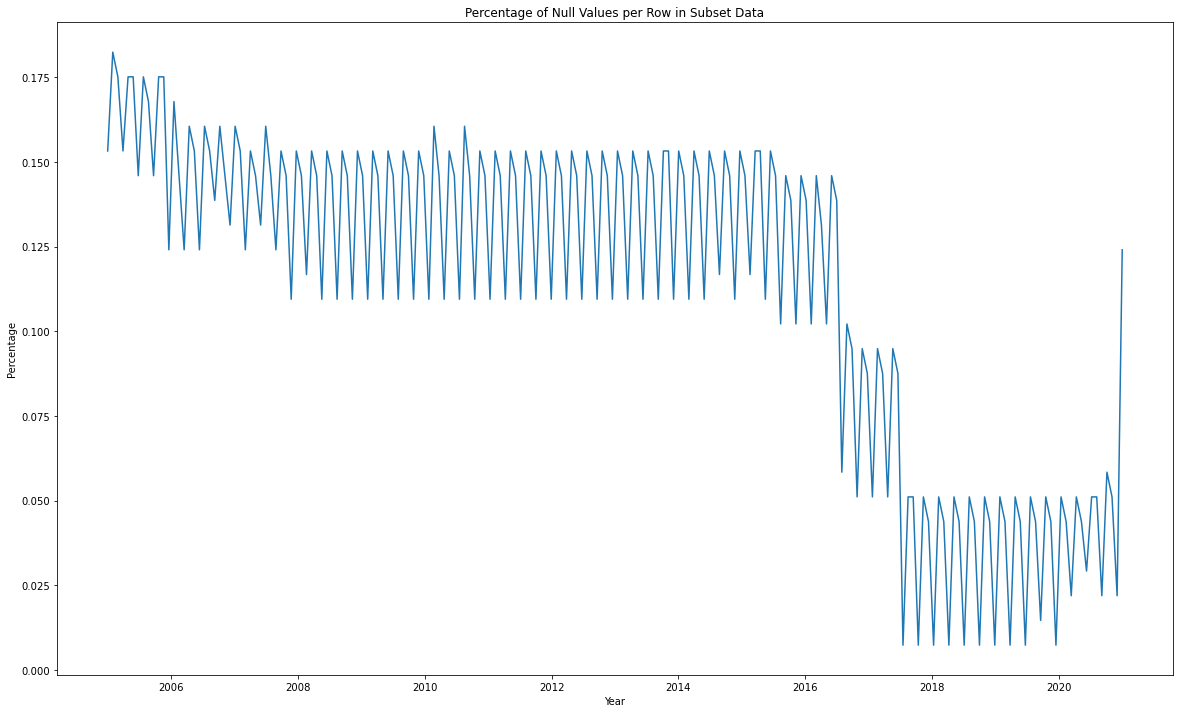

In [7]:
subset = raw[raw["pct_null"] < .2]
fig, ax = plt.subplots(figsize=(20, 12))
x=np.linspace(2005, 2021, 200)
#plt.figsize(20, 12)
plt.plot(x ,subset["pct_null"])
ax.set_ylabel("Percentage")
ax.set_xlabel("Year")
ax.set_title("Percentage of Null Values per Row in Subset Data");

Due to COVID-19, we also wanted to subset the data such that COVID affected dates (beginning in 01/2020) were not taken into consideration.

In [8]:
#Find dates up until 01/2020 to prevent COVID as confounder
subset = subset[[int(list(subset["Month"])[i][3:]) 
                 < 2020 for i in range(len(subset))]]
subset.head()

,Index,Date,Air Safety - General Aviation Fatalities,Highway Fatalities Per 100 Million Vehicle Miles Traveled,Highway Fatalities,U.S. Airline Traffic - Total - Seasonally Adjusted,U.S. Airline Traffic - International - Seasonally Adjusted,U.S. Airline Traffic - Domestic - Seasonally Adjusted,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,...,Light truck sales SAAR (millions),U.S. Airline Traffic - International - Non Seasonally Adjusted,Auto sales SAAR (millions),U.S. Airline Traffic - Domestic - Non Seasonally Adjusted,Transborder - Total North American Freight,Transborder - U.S. - Mexico Freight,U.S. marketing air carriers on-time performance (percent),Transborder - U.S. - Canada Freight,Month,pct_null
696,696,01/01/2005 12:00:00 AM,56.0,NaN,NaN,NaN,NaN,NaN,11611875.0,416054551.0,...,8921000.0,NaN,7448000.0,NaN,NaN,NaN,NaN,NaN,01/2005,0.153285
697,697,02/01/2005 12:00:00 AM,43.0,NaN,NaN,NaN,NaN,NaN,11445295.0,403144202.0,...,8840000.0,NaN,7560000.0,NaN,NaN,NaN,NaN,NaN,02/2005,0.182482
698,698,03/01/2005 12:00:00 AM,37.0,NaN,NaN,NaN,NaN,NaN,13310572.0,473893673.0,...,9168000.0,NaN,7761000.0,NaN,NaN,NaN,NaN,NaN,03/2005,0.175182
699,699,04/01/2005 12:00:00 AM,37.0,NaN,NaN,NaN,NaN,NaN,12907373.0,443809746.0,...,9334000.0,NaN,7939000.0,NaN,NaN,NaN,NaN,NaN,04/2005,0.153285
700,700,05/01/2005 12:00:00 AM,50.0,NaN,NaN,NaN,NaN,NaN,12763833.0,455794647.0,...,9415000.0,NaN,7513000.0,NaN,NaN,NaN,NaN,NaN,05/2005,0.175182


### 1.1.2. Determine columns of interest

First, let's look at our research question in scope: *Research Question 2 (Comparing GLMs and nonparametric methods): Predicting infrastructure spending in 2019 using past infrastructure data (up to 2018) in the US.* 

**Columns to include:** 

1. Include all spending columns (since those our primary covariates)
2. Employment statistics (helps control for natural expansion/reduction of workforces as a result of high/low investment and spending in infrastructure
3. Consumer population and behavior statistics (such as highway death fatalities, rail passengers, transborder volume of passengers, airline traffic, truck sales to help control for population growth and volume of "consumers of infrastructure")
4. Real GDP/US economy valuation (helps control for a "budget constraint" or degree of liquidity for US budget for infrastructure.

As a result, columns that are not directly associated with the above points are dropped.

In [9]:
cols_to_drop = ["Index",
               "Air Safety - General Aviation Fatalities",
                "Highway Fatalities Per 100 Million Vehicle Miles Traveled",
               "Highway Fuel Price - On-highway Diesel",
               "Highway Fuel Price - Regular Gasoline",
               "Passenger Rail Yard Switching Miles",
               "Passenger Rail Total Reports",
               "U.S. Waterway Tonnage",
               "Amtrak On-time Performance",
               "Rail Fatalities at Highway-Rail Crossings",
               "U.S. Airline Traffic - Total - Non Seasonally Adjusted",
               "U.S. Airline Traffic - International - Non Seasonally Adjusted",
               "U.S. marketing air carriers on-time performance (percent)",
                "pct_null"
               ]
subset = subset.drop(cols_to_drop, axis=1)

In [10]:
subset

,Date,Highway Fatalities,U.S. Airline Traffic - Total - Seasonally Adjusted,U.S. Airline Traffic - International - Seasonally Adjusted,U.S. Airline Traffic - Domestic - Seasonally Adjusted,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,Transit Ridership - Urban Rail - Adjusted,Freight Rail Intermodal Units,Freight Rail Carloads,...,Truck tonnage index,U.S. Air Carrier Cargo (millions of revenue ton-miles) - Domestic,Heavy truck sales SAAR (millions),Light truck sales SAAR (millions),Auto sales SAAR (millions),U.S. Airline Traffic - Domestic - Non Seasonally Adjusted,Transborder - Total North American Freight,Transborder - U.S. - Mexico Freight,Transborder - U.S. - Canada Freight,Month
696,01/01/2005 12:00:00 AM,NaN,NaN,NaN,NaN,11611875.0,416054551.0,311945546.0,1004042.0,1538344.0,...,88.2,1.280516e+09,519000.0,8921000.0,7448000.0,NaN,NaN,NaN,NaN,01/2005
697,02/01/2005 12:00:00 AM,NaN,NaN,NaN,NaN,11445295.0,403144202.0,305374953.0,885038.0,1340764.0,...,86.3,1.253130e+09,483000.0,8840000.0,7560000.0,NaN,NaN,NaN,NaN,02/2005
698,03/01/2005 12:00:00 AM,NaN,NaN,NaN,NaN,13310572.0,473893673.0,349880600.0,846425.0,1344164.0,...,85.7,1.469765e+09,484000.0,9168000.0,7761000.0,NaN,NaN,NaN,NaN,03/2005
699,04/01/2005 12:00:00 AM,NaN,NaN,NaN,NaN,12907373.0,443809746.0,335620384.0,1095545.0,1704628.0,...,86.6,1.226824e+09,482000.0,9334000.0,7939000.0,NaN,NaN,NaN,NaN,04/2005
700,05/01/2005 12:00:00 AM,NaN,NaN,NaN,NaN,12763833.0,455794647.0,342804244.0,893384.0,1332755.0,...,85.8,1.261165e+09,486000.0,9415000.0,7513000.0,NaN,NaN,NaN,NaN,05/2005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,08/01/2019 12:00:00 AM,NaN,77600000.0,9600000.0,68230000.0,20593034.0,384027047.0,410170062.0,1089839.0,1055024.0,...,120.4,1.410974e+09,535000.0,12501000.0,4609000.0,72720000.0,1.051030e+11,5.310121e+10,5.200176e+10,08/2019
872,09/01/2019 12:00:00 AM,NaN,77740000.0,9640000.0,68280000.0,18338805.0,396062247.0,410903169.0,1329532.0,1239455.0,...,117.7,1.304838e+09,554000.0,12564000.0,4596000.0,63980000.0,1.014349e+11,5.014872e+10,5.128617e+10,09/2019
873,10/01/2019 12:00:00 AM,9155.0,77650000.0,9590000.0,67920000.0,19083744.0,426327140.0,448819797.0,1063908.0,977406.0,...,118.1,1.433811e+09,505000.0,12330000.0,4395000.0,69920000.0,1.071120e+11,5.335177e+10,5.376023e+10,10/2019
874,11/01/2019 12:00:00 AM,NaN,78830000.0,9660000.0,69370000.0,16328180.0,371791492.0,405041309.0,1019780.0,955392.0,...,117.3,1.413881e+09,456000.0,12700000.0,4401000.0,64820000.0,9.903155e+10,5.010448e+10,4.892707e+10,11/2019


As a further measure of data accuracy, let's see which columns are missing a dangerous proportion of values. For reference, let's remove any columns missing more than 50% of its values. 

In [11]:
# Count number of na's in each column 
series = subset.isna().sum()/len(subset)
missing_cols = series[series > .5]
missing_cols

Highway Fatalities                                                                             0.738889
U.S. Airline Traffic - Total - Seasonally Adjusted                                             0.800000
U.S. Airline Traffic - International - Seasonally Adjusted                                     0.800000
U.S. Airline Traffic - Domestic - Seasonally Adjusted                                          0.800000
Highway Vehicle Miles Traveled - All Systems                                                   0.866667
Highway Vehicle Miles Traveled - Total Rural                                                   0.866667
Highway Vehicle Miles Traveled - Other Rural                                                   0.866667
Highway Vehicle Miles Traveled - Rural Other Arterial                                          0.866667
Highway Vehicle Miles Traveled - Rural Interstate                                              0.866667
National Highway Construction Cost Index (NHCCI)                

In [12]:
# Drop these columns
subset = subset.drop(list(missing_cols.keys()), axis=1)
subset.head()

,Date,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,Transit Ridership - Urban Rail - Adjusted,Freight Rail Intermodal Units,Freight Rail Carloads,State and Local Government Construction Spending - Breakwater/Jetty,State and Local Government Construction Spending - Dam/Levee,State and Local Government Construction Spending - Conservation and Development,State and Local Government Construction Spending - Pump Station,...,U.S. Air Carrier Cargo (millions of revenue ton-miles) - International,Truck tonnage index,U.S. Air Carrier Cargo (millions of revenue ton-miles) - Domestic,Heavy truck sales SAAR (millions),Light truck sales SAAR (millions),Auto sales SAAR (millions),Transborder - Total North American Freight,Transborder - U.S. - Mexico Freight,Transborder - U.S. - Canada Freight,Month
696,01/01/2005 12:00:00 AM,11611875.0,416054551.0,311945546.0,1004042.0,1538344.0,32000000.0,22000000.0,98000000.0,45000000.0,...,1.696944e+09,88.2,1.280516e+09,519000.0,8921000.0,7448000.0,NaN,NaN,NaN,01/2005
697,02/01/2005 12:00:00 AM,11445295.0,403144202.0,305374953.0,885038.0,1340764.0,28000000.0,29000000.0,101000000.0,52000000.0,...,1.561959e+09,86.3,1.253130e+09,483000.0,8840000.0,7560000.0,NaN,NaN,NaN,02/2005
698,03/01/2005 12:00:00 AM,13310572.0,473893673.0,349880600.0,846425.0,1344164.0,38000000.0,36000000.0,116000000.0,49000000.0,...,1.958162e+09,85.7,1.469765e+09,484000.0,9168000.0,7761000.0,NaN,NaN,NaN,03/2005
699,04/01/2005 12:00:00 AM,12907373.0,443809746.0,335620384.0,1095545.0,1704628.0,53000000.0,38000000.0,132000000.0,53000000.0,...,2.078222e+09,86.6,1.226824e+09,482000.0,9334000.0,7939000.0,NaN,NaN,NaN,04/2005
700,05/01/2005 12:00:00 AM,12763833.0,455794647.0,342804244.0,893384.0,1332755.0,50000000.0,39000000.0,142000000.0,53000000.0,...,1.925489e+09,85.8,1.261165e+09,486000.0,9415000.0,7513000.0,NaN,NaN,NaN,05/2005


### 1.1.3. Adjust for null values

In [13]:
subset.isna().sum()[subset.isna().sum() > 0]

Air Safety - Air Taxi and Commuter Fatalities    13
Air Safety - Air Carrier Fatalities              14
Transborder - Total North American Freight       12
Transborder - U.S. - Mexico Freight              12
Transborder - U.S. - Canada Freight              12
dtype: int64

We see that there are 5 columns (out of 110 columns total) that are missing values. These columns are only missing around 13 values each, which comprises <10% of the number of total data points. It would not make sense to drop these columns, since they contain lots of data. Instead, we should adjust for null values by looking at their distributions and decide accordingly. 

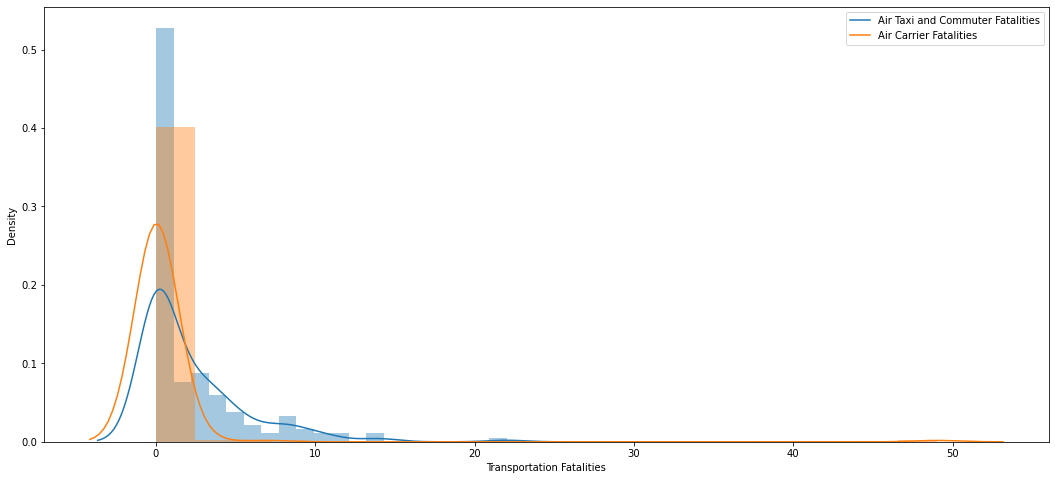

In [14]:
plt.figure(figsize=(18, 8))
sns.distplot(subset["Air Safety - Air Taxi and Commuter Fatalities"],
            bins=20);
sns.distplot(subset["Air Safety - Air Carrier Fatalities"],
            bins=20);
plt.legend(labels=["Air Taxi and Commuter Fatalities","Air Carrier Fatalities"])
plt.xlabel("Transportation Fatalities");

In [15]:
col = "Air Safety - Air Taxi and Commuter Fatalities"
subset[col] = subset[col].fillna(0)
col2 = "Air Safety - Air Carrier Fatalities"
subset[col2] = subset[col2].fillna(0)

From the above distribution plot, we see an overwhelming majority of points have a fatality number of 0. For this reason, we should replace the null values in both air safety columns with the **mode** or **mean** = 0.

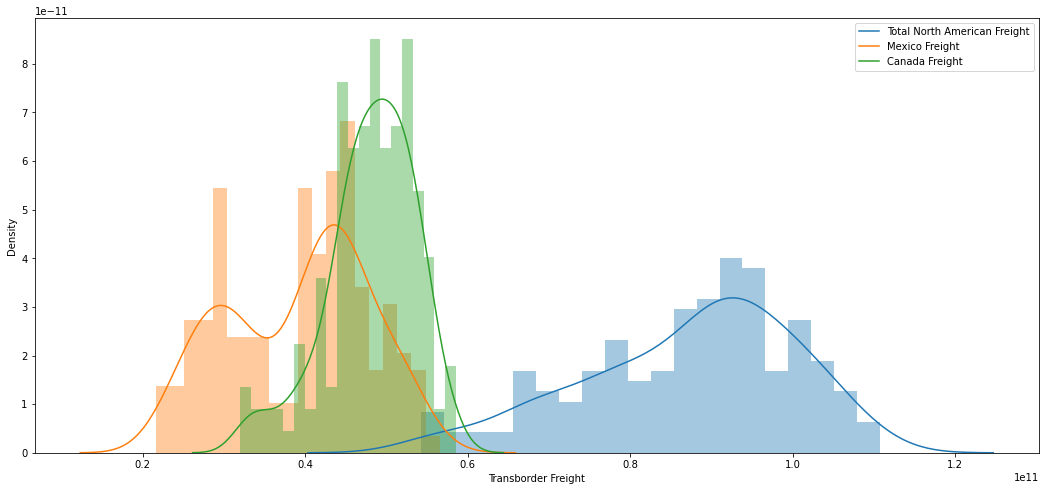

In [16]:
plt.figure(figsize=(18, 8))
sns.distplot(subset["Transborder - Total North American Freight"],
            bins=20);
sns.distplot(subset["Transborder - U.S. - Mexico Freight"],
            bins=20);
sns.distplot(subset["Transborder - U.S. - Canada Freight"],
            bins=20);
plt.xlabel("Transborder Freight")
plt.legend(labels=["Total North American Freight","Mexico Freight", "Canada Freight"]);

From the above distribution plot, we see see that none of the transborder columns are normally distributed. This eliminates the option of replacing these values with the mean. Additionally, it looks as though all three distributions share one commonality: left skewed. Since an overall negative skew is apparent, we should replace all three columns' null values with the **median** since the median is most representative of the "balancing point" for all three distributions. 

In [17]:
cols = ["Transborder - Total North American Freight", 
        "Transborder - U.S. - Mexico Freight", 
        "Transborder - U.S. - Canada Freight"]

for col in cols:
    subset[col] = subset[col].fillna(np.median(subset[col].dropna()))

In [18]:
# Now, the subset of data should have 0 nulls 
check = subset.isna().sum()
check[check > 0]

Series([], dtype: int64)

In [19]:
subset.head()

,Date,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,Transit Ridership - Urban Rail - Adjusted,Freight Rail Intermodal Units,Freight Rail Carloads,State and Local Government Construction Spending - Breakwater/Jetty,State and Local Government Construction Spending - Dam/Levee,State and Local Government Construction Spending - Conservation and Development,State and Local Government Construction Spending - Pump Station,...,U.S. Air Carrier Cargo (millions of revenue ton-miles) - International,Truck tonnage index,U.S. Air Carrier Cargo (millions of revenue ton-miles) - Domestic,Heavy truck sales SAAR (millions),Light truck sales SAAR (millions),Auto sales SAAR (millions),Transborder - Total North American Freight,Transborder - U.S. - Mexico Freight,Transborder - U.S. - Canada Freight,Month
696,01/01/2005 12:00:00 AM,11611875.0,416054551.0,311945546.0,1004042.0,1538344.0,32000000.0,22000000.0,98000000.0,45000000.0,...,1.696944e+09,88.2,1.280516e+09,519000.0,8921000.0,7448000.0,9.006379e+10,4.091667e+10,4.886062e+10,01/2005
697,02/01/2005 12:00:00 AM,11445295.0,403144202.0,305374953.0,885038.0,1340764.0,28000000.0,29000000.0,101000000.0,52000000.0,...,1.561959e+09,86.3,1.253130e+09,483000.0,8840000.0,7560000.0,9.006379e+10,4.091667e+10,4.886062e+10,02/2005
698,03/01/2005 12:00:00 AM,13310572.0,473893673.0,349880600.0,846425.0,1344164.0,38000000.0,36000000.0,116000000.0,49000000.0,...,1.958162e+09,85.7,1.469765e+09,484000.0,9168000.0,7761000.0,9.006379e+10,4.091667e+10,4.886062e+10,03/2005
699,04/01/2005 12:00:00 AM,12907373.0,443809746.0,335620384.0,1095545.0,1704628.0,53000000.0,38000000.0,132000000.0,53000000.0,...,2.078222e+09,86.6,1.226824e+09,482000.0,9334000.0,7939000.0,9.006379e+10,4.091667e+10,4.886062e+10,04/2005
700,05/01/2005 12:00:00 AM,12763833.0,455794647.0,342804244.0,893384.0,1332755.0,50000000.0,39000000.0,142000000.0,53000000.0,...,1.925489e+09,85.8,1.261165e+09,486000.0,9415000.0,7513000.0,9.006379e+10,4.091667e+10,4.886062e+10,05/2005


### 1.1.4 Feature Visualization: Qualitative and Quantitative Variables

A useful visualization would be to look at the correlation between state and local government transportation spending and the features that do not include spending (i.e. ridership statistics, population statistics, etc.) That way, we could see the overall association between spend and metrics relating consumer volume/behavior. Since we want to see which features are strongly correlated (positive or negative), we took the absolute value of the correlation coefficient and sorted them.

In [20]:
# Subset data to cons/dev gov spending and the remaining non-spend cols
col_list = list(subset.columns)
bools = [not "Spending" in col for col in col_list]

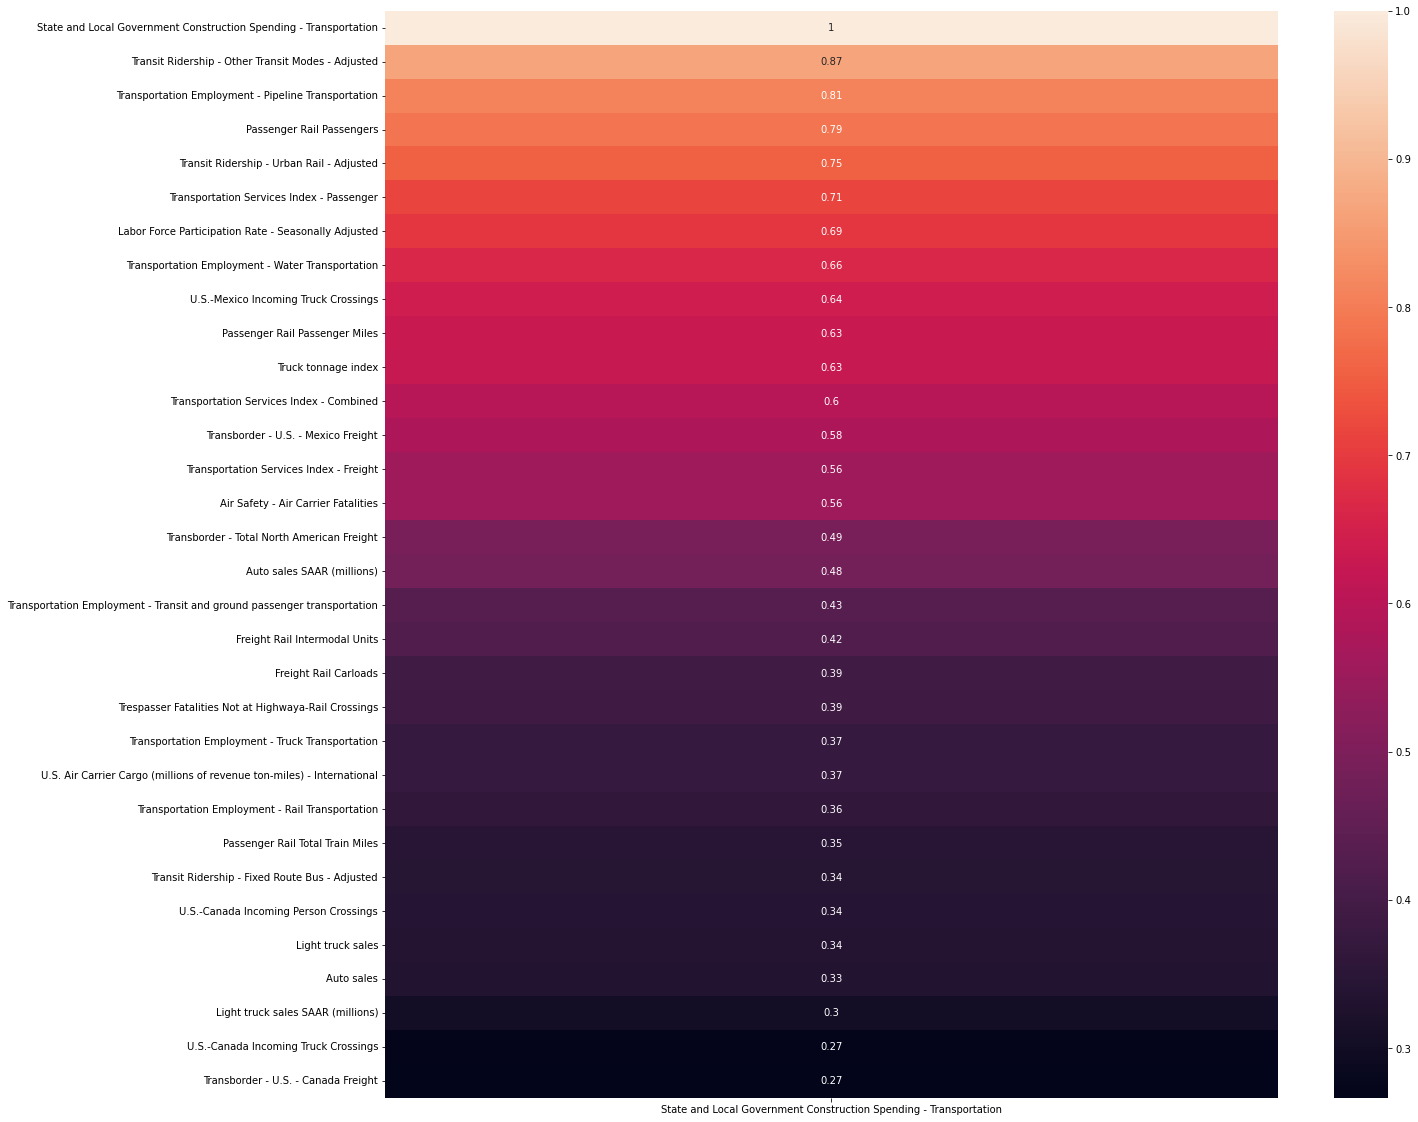

In [21]:
# Visualize heatmap of correlations between spending and non-spending features

cols_for_viz = [col_list[index] for index in np.where(bools)[0]]
for_viz = subset[cols_for_viz].drop(["Date", "Month"], axis=1)
y_col = "State and Local Government Construction Spending - Transportation"
for_viz[y_col] = np.log(subset[[y_col]])
corr = np.log(for_viz).corr()[[y_col]]
corr = abs(corr).sort_values(y_col, ascending=False)
plt.figure(figsize=(20, 20))
subset_corr = corr.loc[corr.mean(axis=1) > 0.2, corr.mean(axis=0) > 0.2]
sns.heatmap(subset_corr, annot=True);

**Observations**

Above, we see the relationship between conservation/development spending and non-spending variables found in the dataset. Overall, all of the non-spending variables were numerical (non-categorical). We also see that the top 5 metrics correlated with higher transportation spending in state and local governments were:

**1. Transit Ridership - Other Transit Modes**

**2. Transportation Employment - Pipeline Transportation**

**3. Passenger Rail Passengers**

**4. Transit Ridership - Urban Rail**

**5. Transportation Services Index - Passenger**

Overall, this can be summarized through the fact that we witness a high association between transportation spending and population in two regards: first, the number of users utilizing public transit, and second, the population/volume of workers in the transportation sector. 

From here, it would be neat to follow up on perhaps why we see a high correlation between spending and variables such as **mobile transit** metrics (as seen through the top five list above) rather than other forms of transportation such as air carrier and cargo shipping. By answering these thoughts and developing a more firm understanding to which non-spending metric impacts/correlates with spending metrics the most, we will be able to select better features for our model to answer our original research question: **Predicting transportation spending in 2019 using past infrastructure data (up to 2018) in the US.**


**Categorical Variables**

There are no qualitative variables in this dataset, so we decided to code the 3 transit ridership features into tiers of very low, low, high, very high. The reason we chose to code the transit ridership features is that they are good indicators of utilization, and the purpose of additional government investment is to meet the demand and / or encourage public transportation. In addition, while the Urban Rail and Other modes of Transit ridership are very correlated to transportation spending, the "Fixed Bus Route" has a somewhat low correlation. It would be interesting to compare the trends of variables with high and low correlation.

2028697.6601536982
16164455.744444445


(11445295.0, 20702522.0)

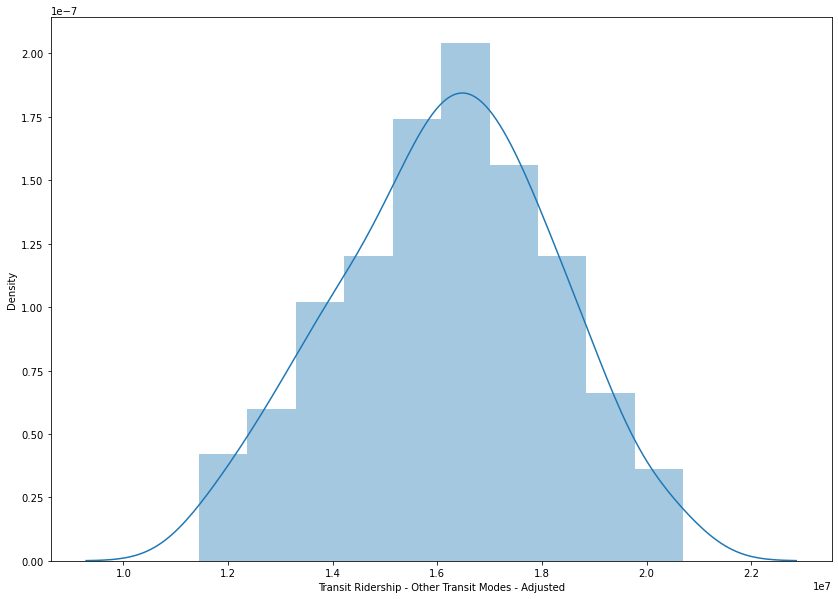

In [22]:
#Other Transit Modes

plt.figure(figsize=(14, 10))
sns.distplot(subset["Transit Ridership - Other Transit Modes - Adjusted"])
print(np.std(subset["Transit Ridership - Other Transit Modes - Adjusted"]))
print(np.mean(subset["Transit Ridership - Other Transit Modes - Adjusted"]))
min(subset["Transit Ridership - Other Transit Modes - Adjusted"]), max(subset["Transit Ridership - Other Transit Modes - Adjusted"])

30186332.70081097
385298127.09444445


(305374953.0, 454743586.0)

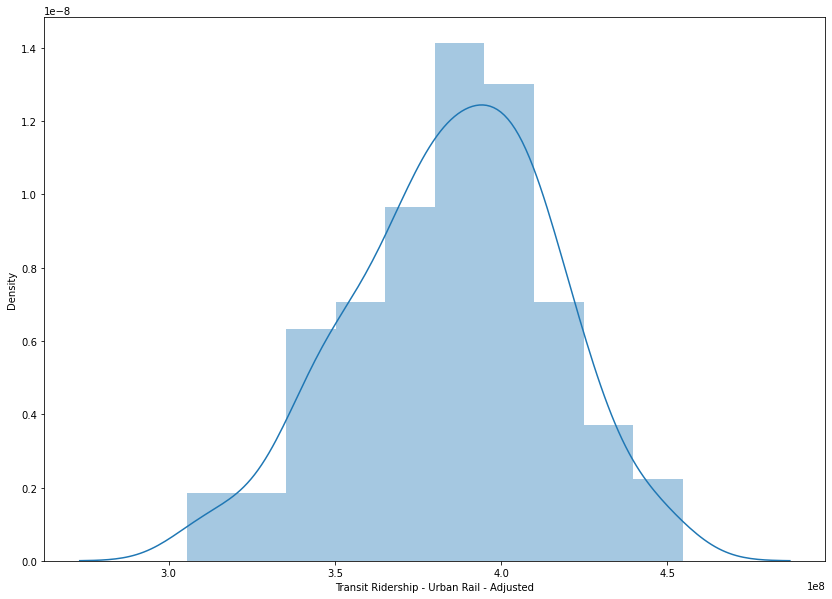

In [23]:
#Urban Rail

plt.figure(figsize=(14, 10))
sns.distplot(subset["Transit Ridership - Urban Rail - Adjusted"])
print(np.std(subset["Transit Ridership - Urban Rail - Adjusted"]))
print(np.mean(subset["Transit Ridership - Urban Rail - Adjusted"]))
min(subset["Transit Ridership - Urban Rail - Adjusted"]), max(subset["Transit Ridership - Urban Rail - Adjusted"])

32217733.02184518
426611771.1722222


(352319744.0, 515540107.0)

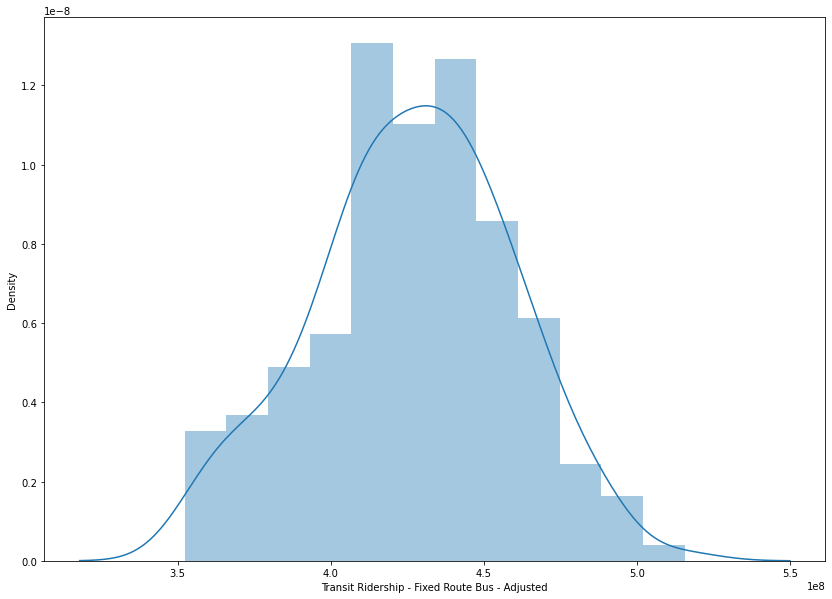

In [24]:
#Other Fixed Route Bus

plt.figure(figsize=(14, 10))
sns.distplot(subset["Transit Ridership - Fixed Route Bus - Adjusted"])
print(np.std(subset["Transit Ridership - Fixed Route Bus - Adjusted"]))
print(np.mean(subset["Transit Ridership - Fixed Route Bus - Adjusted"]))
min(subset["Transit Ridership - Fixed Route Bus - Adjusted"]), max(subset["Transit Ridership - Fixed Route Bus - Adjusted"])

Visualizing the distribution of the 3 transit ridership features shows that their distribution follows a somewhat normal distribution. Because of this, we will use mean +- 1 std dev as the cut-off for the tiers: very low, low, high, and very high.

Below is the code to add in the 3 categorical columns:

In [25]:
#Other Transit Modes
vlo = np.mean(subset["Transit Ridership - Other Transit Modes - Adjusted"]) - np.std(subset["Transit Ridership - Other Transit Modes - Adjusted"])
lo = np.mean(subset["Transit Ridership - Other Transit Modes - Adjusted"])
hi = np.mean(subset["Transit Ridership - Other Transit Modes - Adjusted"]) + np.std(subset["Transit Ridership - Other Transit Modes - Adjusted"])
vlo, lo, hi


(14135758.084290747, 16164455.744444445, 18193153.404598143)

In [26]:
subset["TR_Other"] = subset["Transit Ridership - Other Transit Modes - Adjusted"]
subset.loc[subset.TR_Other.between(0, vlo), "TR_Other"] = 50
subset.loc[subset.TR_Other.between(vlo, lo), "TR_Other"] = 15000000
subset.loc[subset.TR_Other.between(lo, hi), "TR_Other"] = 17000000
subset.loc[subset.TR_Other > hi, "TR_Other"] = 19000000
dict = {50: "very low", 15000000: "low", 17000000: "high", 19000000: "very high"}
subset["TR_Other"] = subset.TR_Other.map(dict)
subset.TR_Other

696     very low
697     very low
698     very low
699     very low
700     very low
         ...    
871    very high
872    very high
873    very high
874         high
875         high
Name: TR_Other, Length: 180, dtype: object

In [27]:
#Urban Rail
vlo = np.mean(subset["Transit Ridership - Urban Rail - Adjusted"]) - np.std(subset["Transit Ridership - Urban Rail - Adjusted"])
lo = np.mean(subset["Transit Ridership - Urban Rail - Adjusted"])
hi = np.mean(subset["Transit Ridership - Urban Rail - Adjusted"]) + np.std(subset["Transit Ridership - Urban Rail - Adjusted"])
vlo, lo, hi

(355111794.3936335, 385298127.09444445, 415484459.7952554)

In [28]:
subset["TR_UR"] = subset["Transit Ridership - Urban Rail - Adjusted"]
subset.loc[subset.TR_UR.between(0, vlo), "TR_UR"] = 50
subset.loc[subset.TR_UR.between(vlo, lo), "TR_UR"] = 370000000
subset.loc[subset.TR_UR.between(lo, hi), "TR_UR"] = 400000000
subset.loc[subset.TR_UR > hi, "TR_UR"] = 420000000
dict = {50: "very low", 370000000: "low", 400000000: "high", 420000000: "very high"}
subset["TR_UR"] = subset.TR_UR.map(dict)
subset.TR_UR

696     very low
697     very low
698     very low
699     very low
700     very low
         ...    
871         high
872         high
873    very high
874         high
875         high
Name: TR_UR, Length: 180, dtype: object

In [29]:
#Fixed Route Bus
vlo = np.mean(subset["Transit Ridership - Fixed Route Bus - Adjusted"]) - np.std(subset["Transit Ridership - Fixed Route Bus - Adjusted"])
lo = np.mean(subset["Transit Ridership - Fixed Route Bus - Adjusted"])
hi = np.mean(subset["Transit Ridership - Fixed Route Bus - Adjusted"]) + np.std(subset["Transit Ridership - Fixed Route Bus - Adjusted"])
vlo, lo, hi

(394394038.15037704, 426611771.1722222, 458829504.19406736)

In [30]:
subset["TR_frb"] = subset["Transit Ridership - Fixed Route Bus - Adjusted"]
subset.loc[subset.TR_frb.between(0, vlo), "TR_frb"] = 50
subset.loc[subset.TR_frb.between(vlo, lo), "TR_frb"] = 400000000
subset.loc[subset.TR_frb.between(lo, hi), "TR_frb"] = 430000000
subset.loc[subset.TR_frb > hi, "TR_frb"] = 460000000
dict = {50: "very low", 400000000: "low", 430000000: "high", 460000000: "very high"}
subset["TR_frb"] = subset.TR_frb.map(dict)
subset.TR_frb

696          low
697          low
698    very high
699         high
700         high
         ...    
871     very low
872          low
873          low
874     very low
875     very low
Name: TR_frb, Length: 180, dtype: object

**Violinplots to Compare Transportation Spending vs. Levels of Transit Ridership**

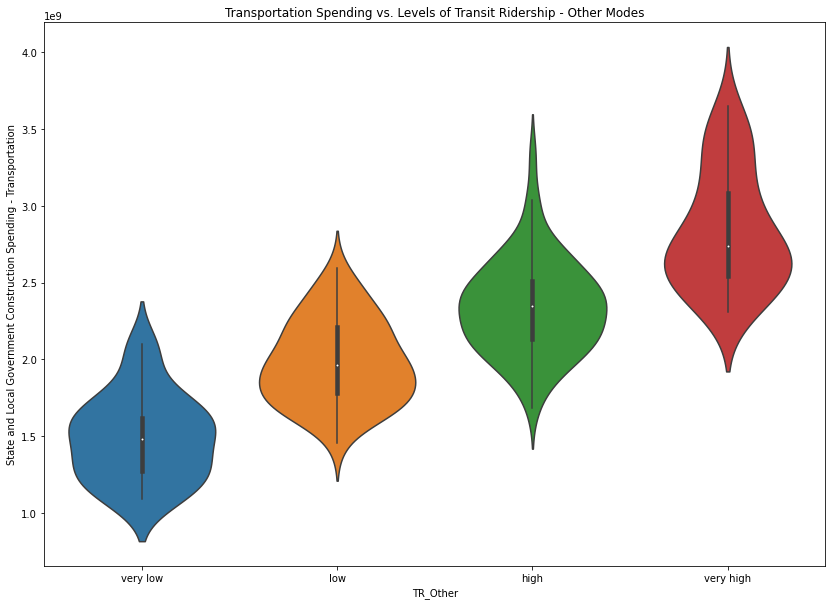

In [31]:
#Other Transit Modes
plt.figure(figsize=(14, 10))
sns.violinplot(x="TR_Other", y="State and Local Government Construction Spending - Transportation", data=subset)
plt.title("Transportation Spending vs. Levels of Transit Ridership - Other Modes");

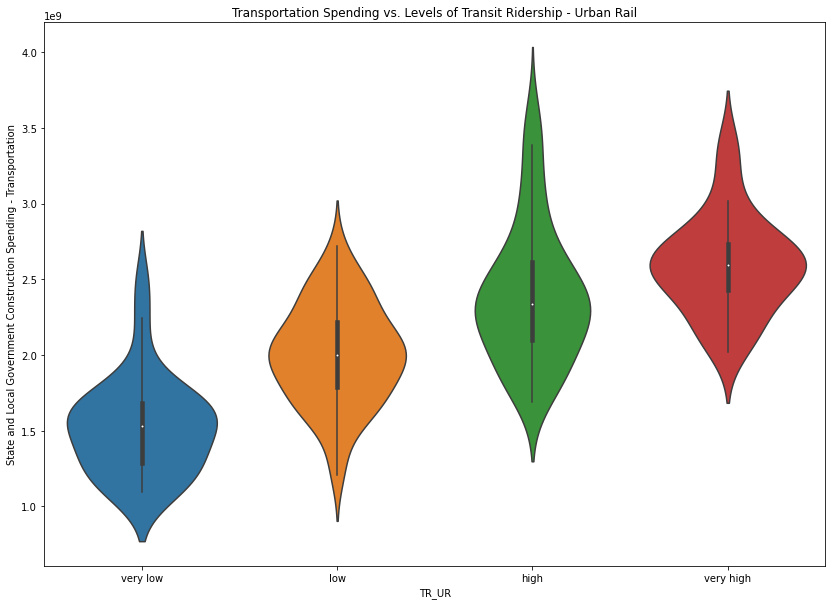

In [32]:
#Urban Rail
plt.figure(figsize=(14, 10))
sns.violinplot(x="TR_UR", y="State and Local Government Construction Spending - Transportation", data=subset);
plt.title("Transportation Spending vs. Levels of Transit Ridership - Urban Rail");

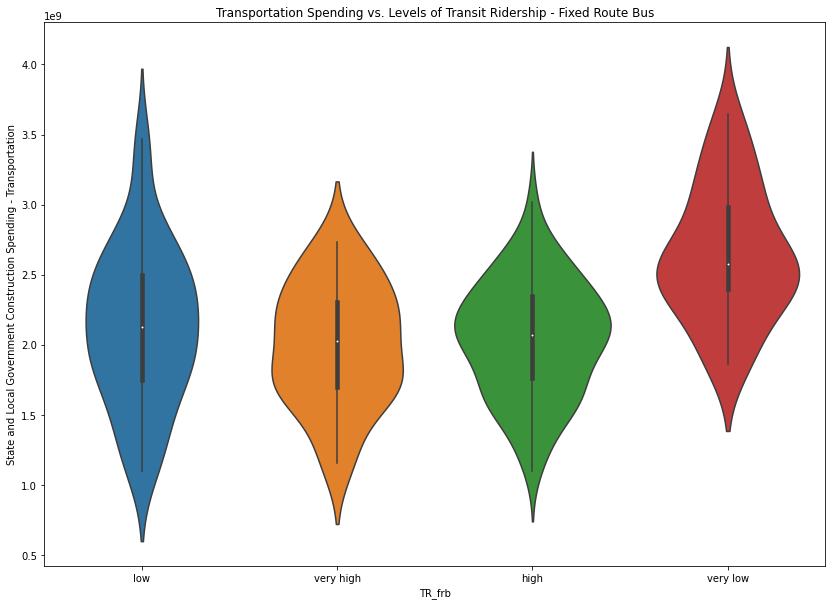

In [33]:
#Fixed Route Bus
plt.figure(figsize=(14, 10))
sns.violinplot(x="TR_frb", y="State and Local Government Construction Spending - Transportation", data=subset);
plt.title("Transportation Spending vs. Levels of Transit Ridership - Fixed Route Bus");

**Observation / Reasoning**


We used a violinplot to compare the categorical variables of transit ridership tiers and the spending on transportation because it is an effective way to visualize the relationship between a quantitative and qualitative variable.

As expected, the Other Modes and Urban Rail showed a much clearer positive correlation to transportation spending, and have less variance in each category. On the other hand, the level of transit ridership for fixed route bus actually showed a negative correlation to transportation spending. The fixed route bus ridership data also has the most spread, suggesting that this negative correlation may have been affected by other variables. Incorporating those other variables that are resulting in this trend would be important to ensure that our model will predict the 2019 spending on transportation more effectively.

## 1.2. Constructing GLM

To establish a GLM, it is important first to distinguish between **bayesian** and **frequentist** models. We recall that the main difference (among others) between the two are that bayesian models hold the unknown parameter to be random (represented by a RV with an appropriate statistical distribution) while frequentist models hold the unknown parameter to be fixed.

As a reminder, our main point of emphasis in this investigation is to use **US transportation spend metrics from 2005-2018 to model and predict transportation spend in 2019**. With this in mind, it is important to recognize that since our outcome variable is national US spending, there are clear exogenous variables that impact this variable. Some of these include: 

1. **National Debt** - the nation's debt influences the baseline of funds available for infrastructure and transportation spending.
2. **Political Atmosphere** - the political party affiliation of both the president as well as the senate and house of representatives influences the baseline willingness to contribute to infrastructure spending. 

There are other variables that may similarly influence our outcome variable of US Transportation Spending. For this reason, we have chosen to proceed with a **Bayesian GLM** since the outcome variable as well as the impact on the outcome variable by other features will *not* be fixed. In reality, there are factors that are constantly influencing the outcome. 

Next, to choose a certain Bayesian GLM to use. In order to evaluate this, we must first look at the distribution of the outcome variable: US Transportation Spending. 

In [34]:
#Reimport Libraries and raw data
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma

import pymc3 as pm
from pymc3 import glm
import statsmodels.api as sm
import arviz

import warnings
warnings.filterwarnings('ignore')

cleaned = subset

# Subset to dates prior to 2019 and save 2019 for test set
cleaned_train = cleaned.iloc[:-12]
cleaned_test = cleaned.iloc[-12:]

### 1.2.1. Determining Strong Features


From the cleaned data, we know that the primary variable of interest (outcome variable) is `State and Local Government Construction Spending - Transportation`. In order to determine which features to use to develop a GLM, let's first identify the historic correlation between transportation metrics (X's) and transportation spending (Y)

In [35]:
# First, take the log of all spending values and one-hot the categorical variables, adding them to the cleaned data
log_spend = for_viz[y_col]
cleaned_train["Log_Transportation_Spending"] = log_spend
temp = cleaned_train.drop(columns=["Date", "Month", "TR_Other", 
                            "TR_UR", "TR_frb", "Log_Transportation_Spending"], axis=1)
log_cleaned_train = np.log(temp)
dummies = pd.get_dummies(cleaned_train[["TR_UR", "TR_Other", "TR_frb"]])
cleaned_train = log_cleaned_train.join(dummies)

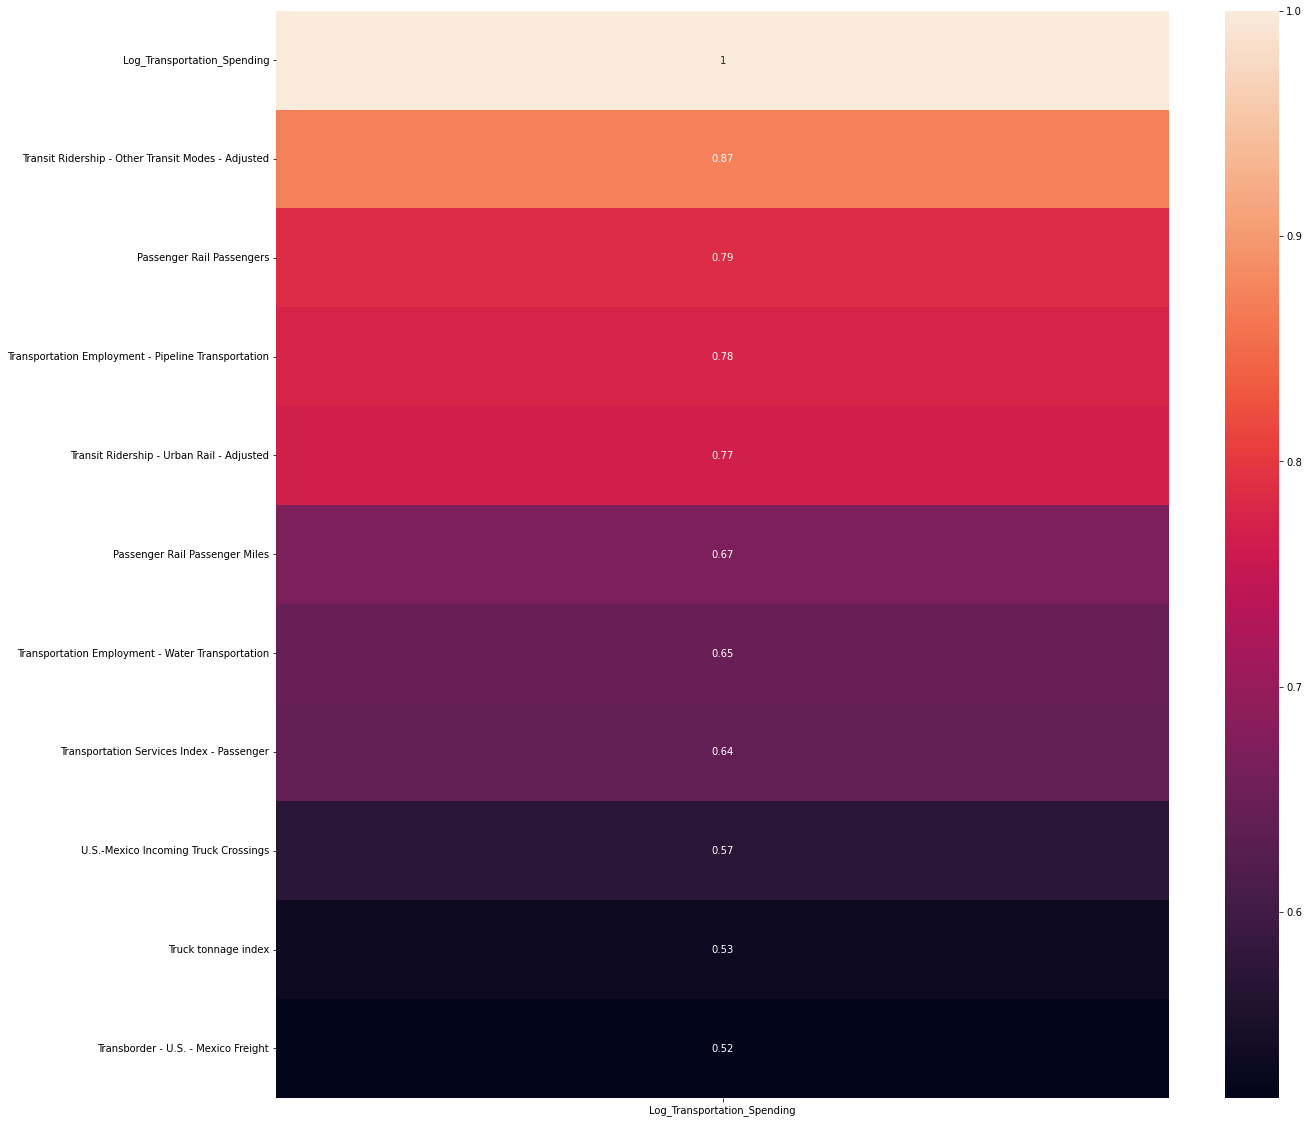

In [36]:
# Visualize heatmap of positive correlations between spending and non-spending features

plt.figure(figsize=(20, 20))

# Subset data to cons/dev gov spending and the remaining non-spend cols
col_list = list(cleaned_train.columns)
bools = [not "Spending" in col for col in col_list]
cols_for_viz = [col_list[index] for index in np.where(bools)[0]]

y_col = "Log_Transportation_Spending"
transp_df = cleaned_train[cols_for_viz]
transp_df[y_col] = log_spend
transp_corr_df = transp_df.corr()[[y_col]]
transp_corr_df = transp_corr_df.sort_values(y_col, ascending=False)
subset_transp_positive_corr_df = transp_corr_df.loc[transp_corr_df.mean(axis=1) >= .5]
sns.heatmap(subset_transp_positive_corr_df, annot=True);


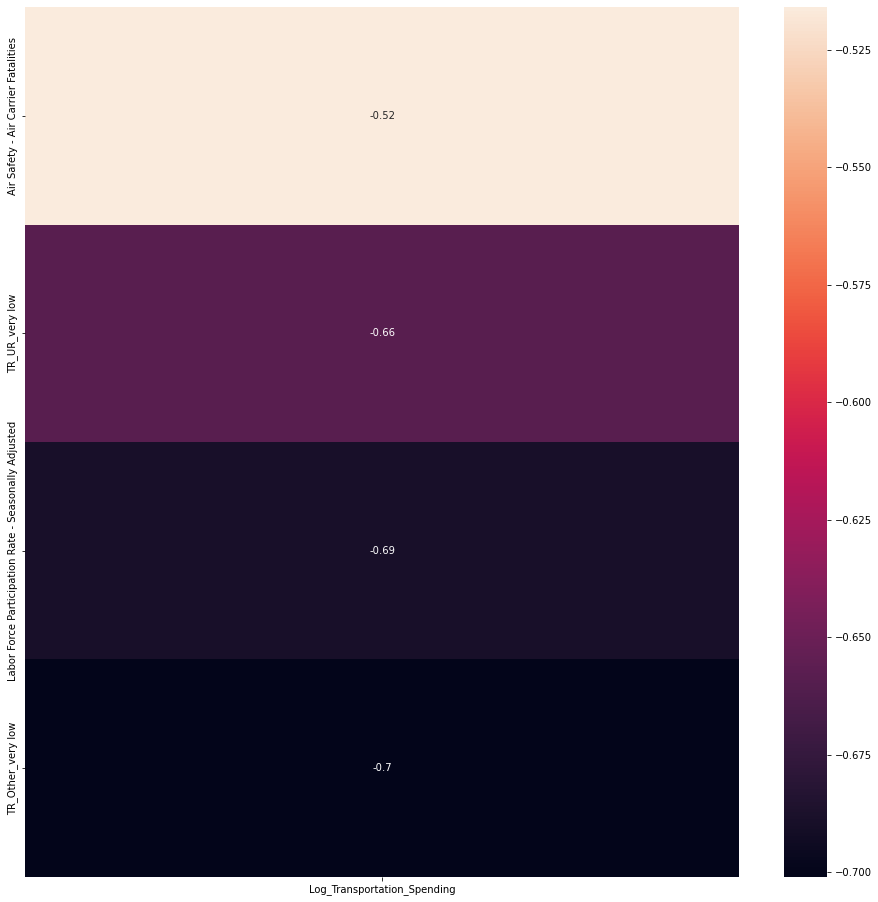

In [37]:
# Visualize negative correlations with y variable (transportation spending)

plt.figure(figsize=(16, 16))

subset_transp_negative_corr_df = transp_corr_df.loc[transp_corr_df.mean(axis=1) <= -.5]
sns.heatmap(subset_transp_negative_corr_df, annot=True);

From the above two heatmaps, we see that with respect to `Log Transportation Spending`, we have a total of 10 moderately strong to strongly positively-correlated features and 4 strongly negatively-correlated features (Note: here, moderately strong correlation is demonstrated by an absolute pearsson value of .5 or greater.

### 1.2.2. Background of Features

In regards to building a GLM, the next step is the develop and indicate any pre-existing information regarding the distribution of the possible features. For convenience, the features have been put into a table below.

| Feature ID      | Feature/Column Name | Correlation |
| ----------- | ----------- | ----------- |
| x1      | Transit Ridership - Other Transit Modes - Adjusted | 0.863 |
| x2   | Passenger Rail Passenger        | 0.775|
| x3   | Transportation Employment - Pipeline Transportation        | 0.764 |
| x4   | Transit Ridership - Urban Rail - Adjusted    |0.758 |
| x5   | Passenger Rail Passenger Miles    | 0.654|
| x6   | Transportation Employment - Water Transportation    | 0.640 |
| x7   | Transportation Services Index - Passenger    | 0.639 |
| x8   | U.S.-Mexico Incoming Truck Crossings    | 0.579 |
| x9   | Truck tonnage index    | 0.546 |
| x10  | Transborder - U.S. - Mexico Freight    | 0.541 |
| x11  | Air Safety - Air Carrier Fatalities   |   -0.520 |
| x12   | TR_UR_very low    | -0.658 | 
| x13   | Labor Force Participation Rate - Seasonally Adjusted    | -0.689 |
| x14   | TR_Other_very low    | -0.700 |

#### Forming Likelihood and Prior

Although we have found the correlation coefficients of the features above, this is not yet enough to warrant specific prior distributions for all 14 features. Additionally, after appropriate research regarding the impacts of each feature on the general spending, there were contrasting perspectives on whether or not each feature had an impact and whether or not it was positive or negative. Likely, this was due to different political perspectives as spending governed by the White House has socio-political implications - most notably demonstrated with the Republican pushback of the otherwise Democratic-backed new infrastructure deal. Thus, each prior has been assessed the un-informative/objective Normal(0, 1) distribution as contrasting sources have eliminated the presence of convicting, one-sided data regarding the prior distributions. 

In [38]:
cleaned_train["Log_Transportation_Spending"] = log_spend
cleaned_train["Air Safety - Air Carrier Fatalities"] = np.e**cleaned_train["Air Safety - Air Carrier Fatalities"]

In [39]:
# For ease of model creation, rename columns to x_is

cleaned_train = cleaned_train.rename({"Transit Ridership - Other Transit Modes - Adjusted": "x1",
               "Transportation Employment - Pipeline Transportation": "x3",
               "Passenger Rail Passengers": "x2",
               "Transportation Services Index - Passenger": "x7",
               "Transit Ridership - Urban Rail - Adjusted": "x4",
               "Truck tonnage index": "x9", 
               "U.S.-Mexico Incoming Truck Crossings": "x8",
               "Labor Force Participation Rate - Seasonally Adjusted": "x8",
               "Transborder - U.S. - Mexico Freight": "x10",
               "Transportation Employment - Water Transportation": "x6",
               "Air Safety - Air Carrier Fatalities" : "x11",
               "TR_UR_very low": "x12",
               "Passenger Rail Passenger Miles": "x5",
               "Labor Force Participation Rate - Seasonally Adjusted": "x13",
               "TR_Other_very low": "x14"
              }, axis=1)

cleaned_train = cleaned_train[["Log_Transportation_Spending", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10",
                "x11", "x12", "x13", "x14"]]

In [40]:
cleaned_train

,Log_Transportation_Spending,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
696,20.841049,16.267539,14.425270,10.547970,19.558339,19.751378,10.924138,4.680278,12.797959,4.479607,24.434803,0.0,1,-0.418550,1
697,20.828526,16.253089,14.400341,10.537415,19.537051,19.677958,10.916905,4.685828,12.812117,4.457830,24.434803,0.0,1,-0.417032,1
698,20.865633,16.404069,14.630733,10.534759,19.673103,19.955025,10.945529,4.685828,12.893514,4.450853,24.434803,0.0,1,-0.417032,1
699,20.955964,16.373309,14.566232,10.540064,19.631491,19.880450,10.992050,4.691348,12.887855,4.461300,24.434803,0.0,1,-0.414001,1
700,20.964642,16.362126,14.602603,10.532096,19.652670,19.951106,11.020267,4.690430,12.890139,4.452019,24.434803,0.0,1,-0.414001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,21.856602,16.845766,14.908451,10.821776,19.803354,20.248716,11.130200,4.877485,13.222645,4.736198,24.703953,0.0,0,-0.466809,0
860,21.815189,16.703359,14.764664,10.829729,19.787361,20.021902,11.103452,4.873669,13.110406,4.746670,24.647892,0.0,0,-0.466809,0
861,21.828191,16.779112,14.848626,10.835652,19.910162,20.110215,11.095894,4.884316,13.250320,4.754452,24.758936,0.0,0,-0.465215,0
862,21.750740,16.645884,14.871585,10.825760,19.788514,20.146211,11.077516,4.877485,13.190801,4.762174,24.686720,0.0,0,-0.463624,0


#### Evaluating Model on Holdout Data

In [41]:
cleaned_test

,Date,Transit Ridership - Other Transit Modes - Adjusted,Transit Ridership - Fixed Route Bus - Adjusted,Transit Ridership - Urban Rail - Adjusted,Freight Rail Intermodal Units,Freight Rail Carloads,State and Local Government Construction Spending - Breakwater/Jetty,State and Local Government Construction Spending - Dam/Levee,State and Local Government Construction Spending - Conservation and Development,State and Local Government Construction Spending - Pump Station,...,Heavy truck sales SAAR (millions),Light truck sales SAAR (millions),Auto sales SAAR (millions),Transborder - Total North American Freight,Transborder - U.S. - Mexico Freight,Transborder - U.S. - Canada Freight,Month,TR_Other,TR_UR,TR_frb
864,01/01/2019 12:00:00 AM,16515635.0,367851089.0,368022820.0,1316168.0,1238487.0,72000000.0,64000000.0,238000000.0,61000000.0,...,522000.0,11503000.0,5241000.0,9.562308e+10,4.959533e+10,4.602775e+10,01/2019,high,low,very low
865,02/01/2019 12:00:00 AM,15136059.0,354692992.0,350068247.0,1094580.0,1000142.0,82000000.0,66000000.0,211000000.0,76000000.0,...,510000.0,11861000.0,4814000.0,9.418898e+10,4.782260e+10,4.636638e+10,02/2019,low,very low,very low
866,03/01/2019 12:00:00 AM,17796909.0,390228157.0,403221955.0,1065841.0,956821.0,104000000.0,67000000.0,232000000.0,72000000.0,...,524000.0,12210000.0,4922000.0,1.072299e+11,5.316518e+10,5.406468e+10,03/2019,high,high,very low
867,04/01/2019 12:00:00 AM,18746430.0,397479345.0,415533810.0,1322588.0,1310228.0,84000000.0,76000000.0,242000000.0,92000000.0,...,570000.0,11668000.0,4760000.0,1.045488e+11,5.259620e+10,5.195258e+10,04/2019,very high,very high,low
868,05/01/2019 12:00:00 AM,19596702.0,399640786.0,421141236.0,1049163.0,1023136.0,104000000.0,80000000.0,266000000.0,79000000.0,...,564000.0,12474000.0,4802000.0,1.097959e+11,5.454501e+10,5.525088e+10,05/2019,very high,very high,low
869,06/01/2019 12:00:00 AM,19006565.0,362002815.0,398791173.0,1075974.0,1023394.0,104000000.0,108000000.0,288000000.0,87000000.0,...,550000.0,12380000.0,4902000.0,1.037658e+11,5.116206e+10,5.260373e+10,06/2019,very high,high,very low
870,07/01/2019 12:00:00 AM,20378395.0,369257081.0,411609150.0,1314363.0,1264354.0,116000000.0,105000000.0,307000000.0,84000000.0,...,565000.0,12339000.0,4692000.0,1.024414e+11,5.222079e+10,5.022060e+10,07/2019,very high,high,very low
871,08/01/2019 12:00:00 AM,20593034.0,384027047.0,410170062.0,1089839.0,1055024.0,120000000.0,129000000.0,335000000.0,60000000.0,...,535000.0,12501000.0,4609000.0,1.051030e+11,5.310121e+10,5.200176e+10,08/2019,very high,high,very low
872,09/01/2019 12:00:00 AM,18338805.0,396062247.0,410903169.0,1329532.0,1239455.0,104000000.0,125000000.0,308000000.0,76000000.0,...,554000.0,12564000.0,4596000.0,1.014349e+11,5.014872e+10,5.128617e+10,09/2019,very high,high,low
873,10/01/2019 12:00:00 AM,19083744.0,426327140.0,448819797.0,1063908.0,977406.0,92000000.0,134000000.0,304000000.0,106000000.0,...,505000.0,12330000.0,4395000.0,1.071120e+11,5.335177e+10,5.376023e+10,10/2019,very high,very high,low


In [42]:
#Clean test data
cleaned_test["Log_Transportation_Spending"] = log_spend
temp = cleaned_test.drop(columns=["Date", "Month", "TR_Other", 
                            "TR_UR", "TR_frb", "Log_Transportation_Spending"], axis=1)
log_cleaned_test = np.log(temp)
dummies = pd.get_dummies(cleaned_test[["TR_UR", "TR_Other", "TR_frb"]])
cleaned_test = log_cleaned_test.join(dummies)
cleaned_test["Log_Transportation_Spending"] = log_spend
cleaned_test["TR_UR_very low"] = 0
cleaned_test["TR_Other_very low"] = 0
cleaned_test["Air Safety - Air Carrier Fatalities"] = np.e**cleaned_test["Air Safety - Air Carrier Fatalities"]


cleaned_test = cleaned_test.rename({"Transit Ridership - Other Transit Modes - Adjusted": "x1",
               "Transportation Employment - Pipeline Transportation": "x3",
               "Passenger Rail Passengers": "x2",
               "Transportation Services Index - Passenger": "x7",
               "Transit Ridership - Urban Rail - Adjusted": "x4",
               "Truck tonnage index": "x9", 
               "U.S.-Mexico Incoming Truck Crossings": "x8",
               "Labor Force Participation Rate - Seasonally Adjusted": "x8",
               "Transborder - U.S. - Mexico Freight": "x10",
               "Transportation Employment - Water Transportation": "x6",
               "Air Safety - Air Carrier Fatalities" : "x11",
               "TR_UR_very low": "x12",
               "Passenger Rail Passenger Miles": "x5",
               "Labor Force Participation Rate - Seasonally Adjusted": "x13",
               "TR_Other_very low": "x14"
              }, axis=1)

cleaned_test = cleaned_test[["Log_Transportation_Spending", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9", "x10",
                "x11", "x12", "x13", "x14"]]

In [43]:
cleaned_test

,Log_Transportation_Spending,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
864,21.607033,16.619818,14.643525,10.831707,19.723656,19.910862,11.063508,4.878246,13.208363,4.750136,24.627162,0.0,0,-0.460449,0
865,21.637555,16.532590,14.587725,10.823770,19.673639,19.808416,11.055641,4.884316,13.147103,4.753590,24.590764,3.0,0,-0.460449,0
866,21.711691,16.694535,14.806115,10.833681,19.814998,20.063592,11.058795,4.896346,13.240244,4.753590,24.696669,0.0,0,-0.460449,0
867,21.804732,16.746514,14.819444,10.837618,19.845075,20.092231,11.080603,4.896346,13.169657,4.759607,24.685910,0.0,0,-0.463624,0
868,21.906832,16.790872,14.879471,10.855145,19.858479,20.172946,11.119883,4.905275,13.265119,4.763028,24.722292,0.0,0,-0.463624,0
869,21.944096,16.760295,14.910177,10.858999,19.803948,20.242362,11.125791,4.902307,13.187317,4.768988,24.658264,0.0,0,-0.463624,0
870,21.976600,16.829986,14.949746,10.864752,19.835585,20.303567,11.144756,4.906755,13.222194,4.775756,24.678746,0.0,0,-0.460449,0
871,22.016622,16.840463,14.932805,10.853213,19.832082,20.255890,11.147642,4.912655,13.217232,4.790820,24.695466,0.0,0,-0.458866,0
872,21.967132,16.724530,14.826481,10.855145,19.833868,20.085244,11.125791,4.915592,13.150478,4.768139,24.638259,0.0,0,-0.460449,0
873,21.949685,16.764347,14.865175,10.855145,19.922132,20.107386,11.130200,4.907495,13.260521,4.771532,24.700173,1.0,0,-0.458866,0


In [44]:
np.random.seed(1)
def model_creator(data):
    with pm.Model() as model:
        # define prior
        my_priors = {"Regressor" : pm.Normal.dist(mu=0, sd=1)}
        # formula 
        glm.GLM.from_formula('Log_Transportation_Spending ~ 0 + x1 + x2 + x3 + x4 + x5 + x6 + x7 + x8 + x9 + x10 + x11 + x12 + x13 + x14',
                         data = data,
                         priors = my_priors,
                         family=glm.families.Normal())
    return model

with model_creator(cleaned_train):
    trace = pm.sample(500, cores=1, target_accept=0.95, return_inferencedata = True)

with model_creator(cleaned_test):
    ppc = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, x14, x13, x12, x11, x10, x9, x8, x7, x6, x5, x4, x3, x2, x1]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 1129 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


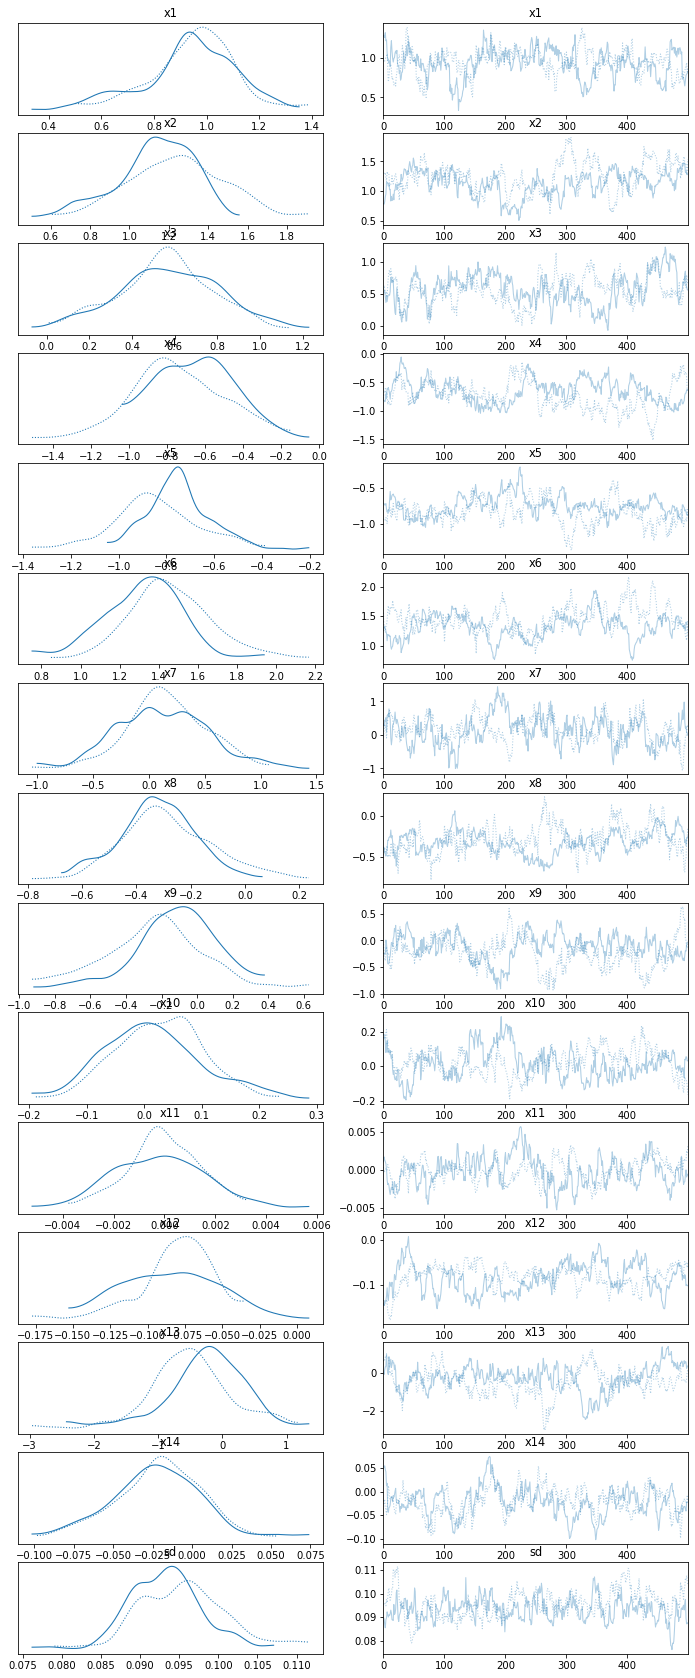

In [45]:
arviz.plot_trace(trace);

In [46]:
summary_df = pm.summary(trace)
summary_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x1,0.942,0.167,0.574,1.228,0.020,0.014,75.0,117.0,1.00
x2,1.185,0.235,0.689,1.592,0.051,0.038,22.0,28.0,1.09
x3,0.565,0.230,0.122,0.984,0.045,0.032,27.0,43.0,1.06
x4,-0.695,0.231,-1.070,-0.236,0.071,0.058,10.0,20.0,1.15
x5,-0.794,0.167,-1.087,-0.468,0.031,0.023,28.0,37.0,1.10
x6,1.392,0.222,0.961,1.825,0.058,0.043,15.0,74.0,1.13
x7,0.141,0.398,-0.623,0.872,0.048,0.034,68.0,77.0,1.02
x8,-0.304,0.155,-0.609,-0.019,0.032,0.023,27.0,89.0,1.06
x9,-0.180,0.268,-0.730,0.318,0.049,0.054,30.0,54.0,1.11
x10,0.021,0.081,-0.122,0.176,0.015,0.011,30.0,82.0,1.06


In [47]:
y_test = list(cleaned_test["Log_Transportation_Spending"])
y_train_df = cleaned_test.drop("Log_Transportation_Spending", axis=1).T
y_train_df["betas"] = summary_df["mean"]

In [48]:
y_train_df

,864,865,866,867,868,869,870,871,872,873,874,875,betas
x1,16.619818,16.532590,16.694535,16.746514,16.790872,16.760295,16.829986,16.840463,16.724530,16.764347,16.608403,16.602928,0.942
x2,14.643525,14.587725,14.806115,14.819444,14.879471,14.910177,14.949746,14.932805,14.826481,14.865175,14.840933,14.842001,1.185
x3,10.831707,10.823770,10.833681,10.837618,10.855145,10.858999,10.864752,10.853213,10.855145,10.855145,10.857074,10.858999,0.565
x4,19.723656,19.673639,19.814998,19.845075,19.858479,19.803948,19.835585,19.832082,19.833868,19.922132,19.819500,19.811685,-0.695
x5,19.910862,19.808416,20.063592,20.092231,20.172946,20.242362,20.303567,20.255890,20.085244,20.107386,20.077358,20.078309,-0.794
x6,11.063508,11.055641,11.058795,11.080603,11.119883,11.125791,11.144756,11.147642,11.125791,11.130200,11.115429,11.101945,1.392
x7,4.878246,4.884316,4.896346,4.896346,4.905275,4.902307,4.906755,4.912655,4.915592,4.907495,4.917057,4.921440,0.141
x8,13.208363,13.147103,13.240244,13.169657,13.265119,13.187317,13.222194,13.217232,13.150478,13.260521,13.157893,13.075504,-0.304
x9,4.750136,4.753590,4.753590,4.759607,4.763028,4.768988,4.775756,4.790820,4.768139,4.771532,4.764735,4.757033,-0.180
x10,24.627162,24.590764,24.696669,24.685910,24.722292,24.658264,24.678746,24.695466,24.638259,24.700173,24.637376,24.566726,0.021


In [49]:
from math import e
def rmse(pred, res):
    return np.sqrt(((pred - res) ** 2).mean())

### 1.2.3. Calculating Training Error of GLM 

In [50]:
y_train = list(cleaned_train["Log_Transportation_Spending"])
x_train_df = cleaned_train.drop("Log_Transportation_Spending", axis=1).T
x_train_df["betas"] = summary_df["mean"]

cols = list(x_train_df.columns)
y_preds = []
for col in cols:
    y_preds.append(sum(x_train_df[col] * x_train_df["betas"]))

y_preds = y_preds[:-1]

# Train Set Error
train_rmse = rmse(np.array(y_preds), np.array(y_train))
log_train_rmse = rmse(np.array(y_preds), np.array(y_train))
train_rmse, log_train_rmse
print("Training set error for GLM (Log Dollars):    ", train_rmse)

Training set error for GLM (Log Dollars):     0.0904754014995469


In [51]:
#non log rmse
rmse(np.e**np.array(y_preds), np.e**np.array(y_train)) 

194200157.1775764

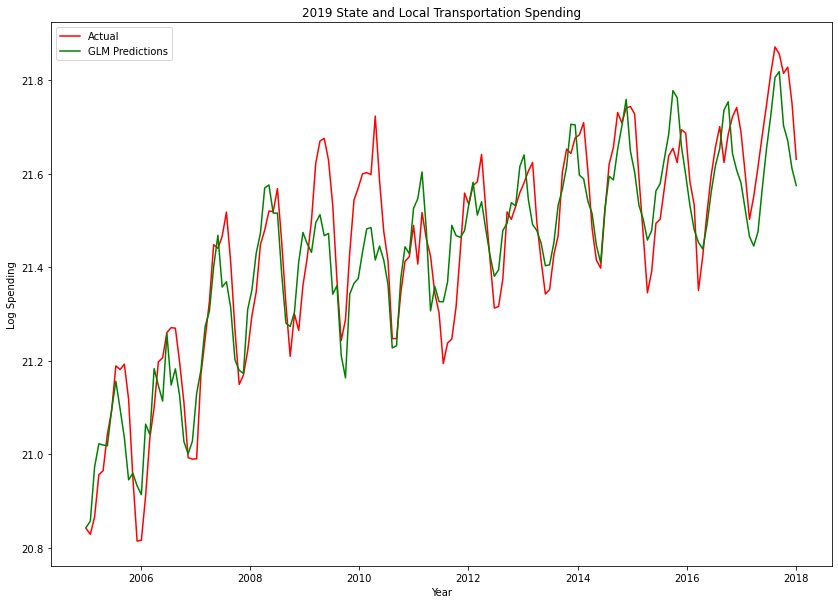

In [52]:
plt.figure(figsize=(14, 10))
x = np.linspace(2005, 2018, 168)
plt.plot(x, y_train, color='red', label="Actual")
plt.plot(x, y_preds, color='green', label="GLM Predictions")
plt.xlabel("Year")
plt.ylabel("Log Spending")
plt.legend(loc="upper left")
plt.title("2019 State and Local Transportation Spending");

### 1.2.4. Calculating Test Error of GLM 

In [53]:
# Test Set Error

y_test = list(cleaned_test["Log_Transportation_Spending"])
x_test_df = cleaned_test.drop("Log_Transportation_Spending", axis=1).T
x_test_df["betas"] = summary_df["mean"]

cols = list(x_test_df.columns)
y_preds = []
for col in cols:
    y_preds.append(sum(x_test_df[col] * x_test_df["betas"]))

y_preds = y_preds[:-1]

test_rmse = rmse(np.array(y_preds), np.array(y_test))
log_test_rmse = rmse(np.array(y_preds), np.array(y_test))
test_rmse, log_test_rmse

print("Test set error for GLM (Log Dollars):    ", test_rmse)

Test set error for GLM (Log Dollars):     0.1755747575141033


In [54]:
#non log test rmse
rmse(np.e**np.array(y_preds), np.e**np.array(y_test))

521960888.6152375

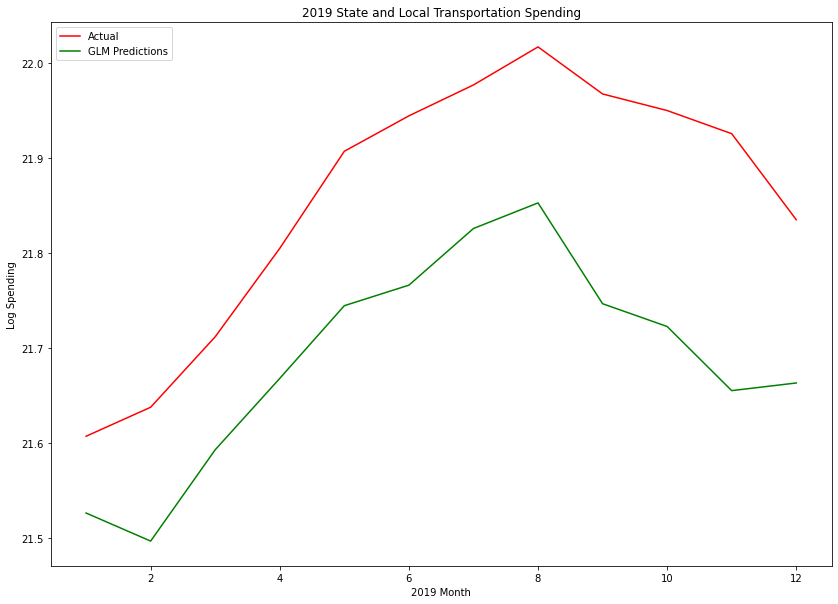

In [55]:
plt.figure(figsize=(14, 10))
x = np.linspace(1, 12, 12)
plt.plot(x, y_test, color='red', label="Actual")
plt.plot(x, y_preds, color='green', label="GLM Predictions")
plt.xlabel("2019 Month")
plt.ylabel("Log Spending")
plt.legend(loc="upper left")
plt.title("2019 State and Local Transportation Spending");

## 1.3. Forming Non-Parametric Model

### 1.3.1. Visualize the data we have to assess which model would be most fitting

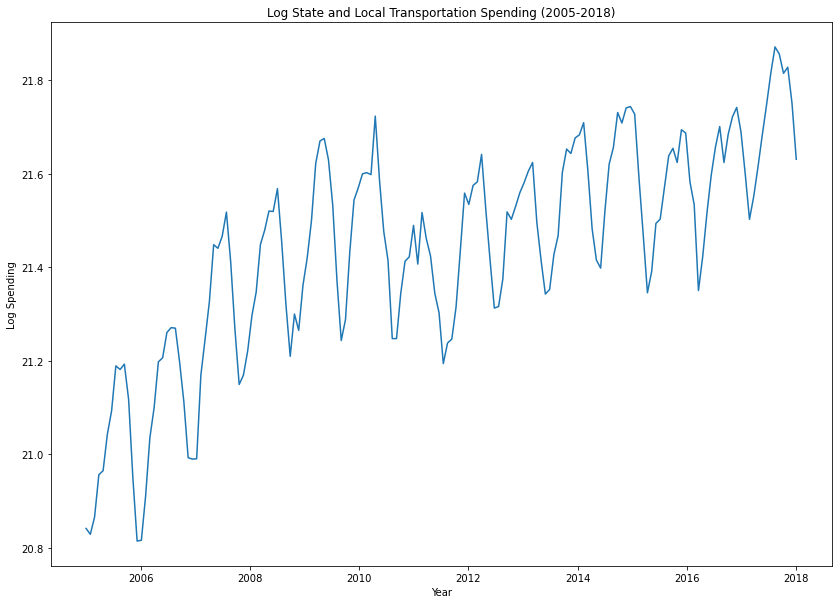

In [56]:
plt.figure(figsize=(14, 10))
x = np.linspace(2005, 2018, 168)
y = np.log(subset["State and Local Government Construction Spending - Transportation"])[:-12]
plt.plot(x, y)
plt.ylabel("Log Spending")
plt.xlabel("Year")
plt.title("Log State and Local Transportation Spending (2005-2018)");

**What we're trying to predict:** State and Local Government Construction Spending - Transportation in 2019. Since spending is listed in a monthly manner, we will be predicting the 12 monthly spending on transportation in 2019.

**Features to Use:** To build our model, we decided to use the features that have a somewhat strong correlation to our response variable. We selected 16 features that have a greater absolute correlation coefficient than 0.5.

**Nonparametric method to use:** Random Forest Regression. 

Random forests are ensemble models that reduce the variance from decision trees. Because of the aggregation, they are not prone to overfit. Compared to a neural network, the features of a random forest are much more interpretable. In a practical setting, if the city wanted to analyze what factors contribute the most to, or are most related to spending on transportation, a neural network would not be able to provide insight, while a random forest could.

**Assumptions made by modeling choice:** There are no formal assumptions that are implicit to a random forest. However, as seen above, the state and local spending on transportation data shows a lot of noise though it is generally trending upwards, so the generality of a random forest is assumed to be helpful.

### 1.3.2. Creating the Random Forest Model
We are using the 14 features that are moderately-high correlated to State and Local Transportation spending.

**Train / Test Data:**
- Train: 2005 - 2018 data on the 14 features + Transportation Spending (168 x 14)
- Test: 2019 data on the 14 features + Transportation Spending (12 x 14)

**Hyperparameters:**
- 100 trees
- no limit on tree depth
- 5 features per tree - ~1/3 of the 14 features

**Error Metrics:** RMSE

In [57]:
def rmse(pred, res):
    return np.sqrt(((pred - res) ** 2).mean())

Narrowed the general dataset to only include 14 features, and set the index by date.

In [58]:
positive_features = np.array(subset_transp_positive_corr_df.reset_index()["index"])
negative_features = np.array(subset_transp_negative_corr_df.reset_index()["index"])
all_feats = np.append(positive_features, negative_features)
all_feats = np.append(all_feats, "Date")
all_feats

array(['Log_Transportation_Spending',
       'Transit Ridership - Other Transit Modes - Adjusted',
       'Passenger Rail Passengers',
       'Transportation Employment - Pipeline Transportation',
       'Transit Ridership - Urban Rail - Adjusted',
       'Passenger Rail Passenger Miles',
       'Transportation Employment - Water Transportation',
       'Transportation Services Index - Passenger',
       'U.S.-Mexico Incoming Truck Crossings', 'Truck tonnage index',
       'Transborder - U.S. - Mexico Freight',
       'Air Safety - Air Carrier Fatalities', 'TR_UR_very low',
       'Labor Force Participation Rate - Seasonally Adjusted',
       'TR_Other_very low', 'Date'], dtype=object)

In [59]:
subset["Log_Transportation_Spending"] = log_spend
temp = subset.drop(columns=["Date", "Month", "TR_Other", 
                            "TR_UR", "TR_frb", "Log_Transportation_Spending"], axis=1)
log_cleaned = np.log(temp)
dummies = pd.get_dummies(subset[["TR_UR", "TR_Other", "TR_frb"]])
cleaned = log_cleaned.join(dummies)

col_list = list(cleaned.columns)
bools = [not "Spending" in col for col in col_list]
cols_for_viz = [col_list[index] for index in np.where(bools)[0]]

y_col = "Log_Transportation_Spending"
transp_df = cleaned[cols_for_viz]
transp_df[y_col] = log_spend

In [60]:
transp_df["Date"] = subset["Date"]
#transp_df = transp_df.set_index("Date")
clean = transp_df[all_feats]
clean["Air Safety - Air Carrier Fatalities"] = np.e**clean["Air Safety - Air Carrier Fatalities"]
clean = clean.set_index("Date")

In [61]:
clean.head()

,Log_Transportation_Spending,Transit Ridership - Other Transit Modes - Adjusted,Passenger Rail Passengers,Transportation Employment - Pipeline Transportation,Transit Ridership - Urban Rail - Adjusted,Passenger Rail Passenger Miles,Transportation Employment - Water Transportation,Transportation Services Index - Passenger,U.S.-Mexico Incoming Truck Crossings,Truck tonnage index,Transborder - U.S. - Mexico Freight,Air Safety - Air Carrier Fatalities,TR_UR_very low,Labor Force Participation Rate - Seasonally Adjusted,TR_Other_very low
Date,,,,,,,,,,,,,,,
01/01/2005 12:00:00 AM,20.841049,16.267539,14.425270,10.547970,19.558339,19.751378,10.924138,4.680278,12.797959,4.479607,24.434803,0.0,1,-0.418550,1
02/01/2005 12:00:00 AM,20.828526,16.253089,14.400341,10.537415,19.537051,19.677958,10.916905,4.685828,12.812117,4.457830,24.434803,0.0,1,-0.417032,1
03/01/2005 12:00:00 AM,20.865633,16.404069,14.630733,10.534759,19.673103,19.955025,10.945529,4.685828,12.893514,4.450853,24.434803,0.0,1,-0.417032,1
04/01/2005 12:00:00 AM,20.955964,16.373309,14.566232,10.540064,19.631491,19.880450,10.992050,4.691348,12.887855,4.461300,24.434803,0.0,1,-0.414001,1
05/01/2005 12:00:00 AM,20.964642,16.362126,14.602603,10.532096,19.652670,19.951106,11.020267,4.690430,12.890139,4.452019,24.434803,0.0,1,-0.414001,1


In [62]:
#Train-test split
X_train = clean.iloc[:168, 1:]
y_train = clean["Log_Transportation_Spending"][:168]
X_test = clean.iloc[168:, 1:]
y_test = clean["Log_Transportation_Spending"][168:]

Set up a train / test table to measure the accuracy of the model:

In [63]:
train = pd.DataFrame({"Transportation Spending": y_train})
test = pd.DataFrame({"Transportation Spending": y_test})

In [64]:
train

,Transportation Spending
Date,
01/01/2005 12:00:00 AM,20.841049
02/01/2005 12:00:00 AM,20.828526
03/01/2005 12:00:00 AM,20.865633
04/01/2005 12:00:00 AM,20.955964
05/01/2005 12:00:00 AM,20.964642
...,...
08/01/2018 12:00:00 AM,21.856602
09/01/2018 12:00:00 AM,21.815189
10/01/2018 12:00:00 AM,21.828191


In [65]:
X_train

,Transit Ridership - Other Transit Modes - Adjusted,Passenger Rail Passengers,Transportation Employment - Pipeline Transportation,Transit Ridership - Urban Rail - Adjusted,Passenger Rail Passenger Miles,Transportation Employment - Water Transportation,Transportation Services Index - Passenger,U.S.-Mexico Incoming Truck Crossings,Truck tonnage index,Transborder - U.S. - Mexico Freight,Air Safety - Air Carrier Fatalities,TR_UR_very low,Labor Force Participation Rate - Seasonally Adjusted,TR_Other_very low
Date,,,,,,,,,,,,,,
01/01/2005 12:00:00 AM,16.267539,14.425270,10.547970,19.558339,19.751378,10.924138,4.680278,12.797959,4.479607,24.434803,0.0,1,-0.418550,1
02/01/2005 12:00:00 AM,16.253089,14.400341,10.537415,19.537051,19.677958,10.916905,4.685828,12.812117,4.457830,24.434803,0.0,1,-0.417032,1
03/01/2005 12:00:00 AM,16.404069,14.630733,10.534759,19.673103,19.955025,10.945529,4.685828,12.893514,4.450853,24.434803,0.0,1,-0.417032,1
04/01/2005 12:00:00 AM,16.373309,14.566232,10.540064,19.631491,19.880450,10.992050,4.691348,12.887855,4.461300,24.434803,0.0,1,-0.414001,1
05/01/2005 12:00:00 AM,16.362126,14.602603,10.532096,19.652670,19.951106,11.020267,4.690430,12.890139,4.452019,24.434803,0.0,1,-0.414001,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08/01/2018 12:00:00 AM,16.845766,14.908451,10.821776,19.803354,20.248716,11.130200,4.877485,13.222645,4.736198,24.703953,0.0,0,-0.466809,0
09/01/2018 12:00:00 AM,16.703359,14.764664,10.829729,19.787361,20.021902,11.103452,4.873669,13.110406,4.746670,24.647892,0.0,0,-0.466809,0
10/01/2018 12:00:00 AM,16.779112,14.848626,10.835652,19.910162,20.110215,11.095894,4.884316,13.250320,4.754452,24.758936,0.0,0,-0.465215,0


### 1.3.3. Testing Random Forest w/ RMSE

In [66]:
from sklearn.ensemble import RandomForestRegressor


forest_model = RandomForestRegressor(n_estimators = 150, max_features = 5, max_depth = 10, random_state=4)
forest_model.fit(X_train, y_train)

train["forest_pred"] = forest_model.predict(X_train)
train_rmse = rmse(train.iloc[:, 0], train.iloc[:, 1])
test["forest_pred"] = forest_model.predict(X_test)
test_rmse = rmse(test.iloc[:, 0], test.iloc[:, 1])

In [67]:
print("Training set error for random forest:", train_rmse)
print("Test set error for random forest:    ", test_rmse)

Training set error for random forest: 0.031309830312467736
Test set error for random forest:     0.14847601446247302


In [68]:
#remove log transformation
train_rmse = rmse(np.e**train.iloc[:, 0], np.e**train.iloc[:, 1])
test_rmse = rmse(np.e**test.iloc[:, 0], np.e**test.iloc[:, 1])

In [69]:
train_rmse, test_rmse

(64152531.63182865, 453046908.25875473)

**Plot the predictions of the forest and the actual values of transportation spending from 2005 - 2018.**

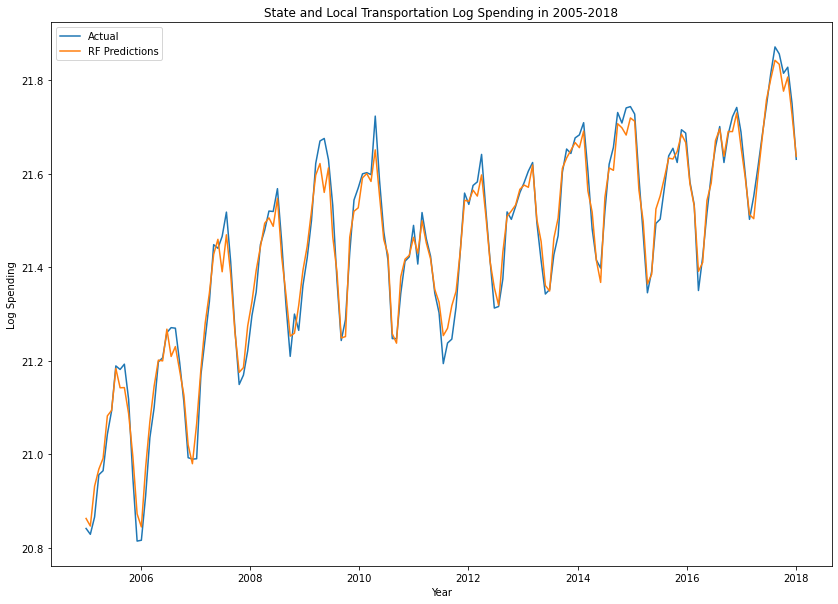

In [102]:
plt.figure(figsize=(14, 10))
x = np.linspace(2005, 2018, 168)
y = subset["Log_Transportation_Spending"][:-12]
plt.plot(x, y, label="Actual")
plt.plot(x, train['forest_pred'], label="RF Predictions")
plt.ylabel("Log Spending")
plt.xlabel("Year")
plt.legend(loc="upper left")
plt.title("State and Local Transportation Log Spending in 2005-2018");

**Plot the actual values of 2019 Transportation Spending Data vs. predicted values**

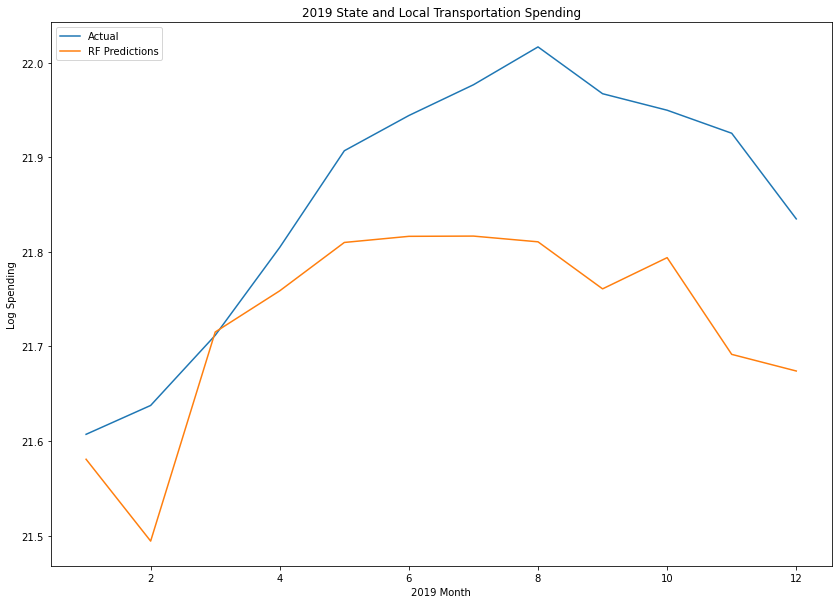

In [103]:
plt.figure(figsize=(14, 10))
x = np.linspace(1, 12, 12)
y = subset["Log_Transportation_Spending"][168:]
plt.plot(x, y, label="Actual")
plt.plot(x, test['forest_pred'], label="RF Predictions")
plt.ylabel("Log Spending")
plt.xlabel("2019 Month")
plt.legend(loc="upper left")
plt.title("2019 State and Local Transportation Spending");

## 1.3. Comparing GLM vs. Non-Parametric Model

First, we can look at the predictions from each model and compare it to the true 2019 spending values. These can be found plotted below:

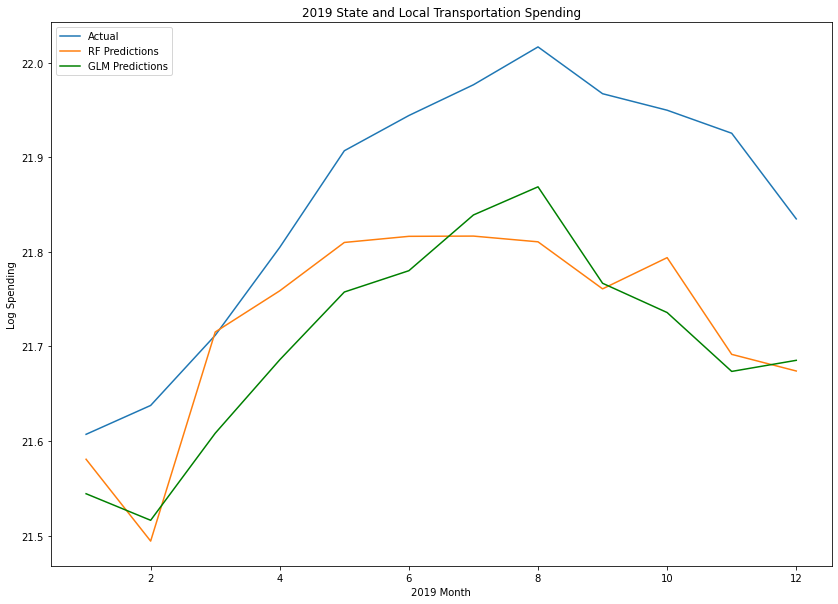

In [104]:
plt.figure(figsize=(14, 10))
x = np.linspace(1, 12, 12)
y = subset["Log_Transportation_Spending"][168:]
plt.plot(x, y, label="Actual")
plt.plot(x, test['forest_pred'], label="RF Predictions")
plt.plot(x, y_preds, color='green', label="GLM Predictions")
plt.legend(loc="upper left")
plt.ylabel("Log Spending")
plt.xlabel("2019 Month")
plt.title("2019 State and Local Transportation Spending");

In order to quantify this, we look at the RSME values for the training and test set, summarized below:

**Training Set Error Metrics** 

| Model Type | RMSE in Log-Transformed Dollars | RMSE in Dollars | 
| ------- | ------- | ------- |
|**Non Parametric Model** | 0.031 | 64,152,531.63 |
|**GLM** | 0.0904 | 194,200,157 |


**Testing Set Error Metrics** 

| Model Type | RMSE in Log-Transformed Dollars | RMSE in Dollars | 
| ------- | ------- | ------- |
|**Non Parametric Model** | 0.148 | 453,046,908.25 |
|**GLM** | 0.1755 | 521,960,888.34 |

### 1.3.1. Discussion

Though expanded further in the investigation, we notice that intuitively, a RF has a very low training set error and a much higher testing set error (with respect to its training rmse) due to the nature of overfitting. Additionally, the GLM experiences a higher testing RMSE with respect to the RF testing RMSE due to its lack of utilizing subjective and informative priors. Since the prior distributions were uninformative, its broadness has resulted in the high overall degree of error. 

From the plot above, it appears that each model predicts the true amount of spending with higher accuracy for different months. The RF predicts the level of 2019 spending (on a log level) better up to mid-June while the GLM predicts better for a brief period between mid-June and September. On a month by month basis, the RF tracks the amount of 2019 spending with higher degree of accuracy (hence the lower test RMSE). However, we see that in terms of overall shape, the GLM captures the cyclic pattern of transportation spending slightly better due to the relatively higher  variance of the random forest (sensitivity to noise/outliers). Though, overall, we conclude that the RF was a better choice of model than the GLM (for additional reasons found in the analysis paper) when predicting future US Transportation Spending. 

# 2. Causality Analysis

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import matplotlib.image as mpimg
# Loading the instrastructure dataset as a Pandas dataframe
infra = pd.read_csv("Monthly_Transportation_Statistics.csv")

#### Research Question

Does investment in infrastructure have an causal impact on the utilization of infrastructure in the US? Specifically, does the change in state and local spending on land passenger terminals have a causal effect on the number of passenger rail passenger miles, and if so is it a positive or negative effect?

## 2.1. Causality EDA

### 2.1.1. Initial EDA

#### Organizing Columns

Our research question deals with the causal effect of infrastructure investment on infrastructure utilization, so a good starting move was to sort the variables at our disposal based on whether they were related to infrastructure or utilization

In [71]:
# Keeping a list of utilization-based columns
utilization_cols = ['U.S. Airline Traffic - Total - Seasonally Adjusted',
 'U.S. Airline Traffic - International - Seasonally Adjusted',
 'U.S. Airline Traffic - Domestic - Seasonally Adjusted',
 'Transit Ridership - Other Transit Modes - Adjusted',
 'Transit Ridership - Fixed Route Bus - Adjusted',
 'Transit Ridership - Urban Rail - Adjusted',
 'Freight Rail Intermodal Units',
 'Freight Rail Carloads',
 'Highway Vehicle Miles Traveled - All Systems',
 'Highway Vehicle Miles Traveled - Total Rural',
 'Highway Vehicle Miles Traveled - Other Rural',
 'Highway Vehicle Miles Traveled - Rural Other Arterial',
 'Highway Vehicle Miles Traveled - Rural Interstate',
 'Personal Spending on Transportation - Transportation Services - Seasonally Adjusted',
 'Personal Spending on Transportation - Gasoline and Other Energy Goods - Seasonally Adjusted',
 'Personal Spending on Transportation - Motor Vehicles and Parts - Seasonally Adjusted',
 'Passenger Rail Passengers',
 'Passenger Rail Passenger Miles',
 'Passenger Rail Total Train Miles',
 'Passenger Rail Employee Hours Worked',
 'Passenger Rail Yard Switching Miles',
 'Passenger Rail Total Reports',
 'U.S. Waterway Tonnage',
 'Transportation Services Index - Freight',
 'Transportation Services Index - Passenger',
 'Transportation Services Index - Combined',
 'U.S.-Canada Incoming Person Crossings',
 'U.S.-Canada Incoming Truck Crossings',
 'U.S.-Mexico Incoming Person Crossings',
 'U.S.-Mexico Incoming Truck Crossings',
 'U.S. Air Carrier Cargo (millions of revenue ton-miles) - International',
 'Truck tonnage index',
 'U.S. Air Carrier Cargo (millions of revenue ton-miles) - Domestic',
 'U.S. Airline Traffic - Total - Non Seasonally Adjusted',
 'U.S. Airline Traffic - Domestic - Non Seasonally Adjusted',
 'Transborder - Total North American Freight',
 'Transborder - U.S. - Mexico Freight',
 'Transborder - U.S. - Canada Freight']

In [72]:
# Keeping a list of investment-based columns, which we named spending because investment
# Consisted of government spending on infrastructure
spendings = ['State and Local Government Construction Spending - Breakwater/Jetty',
 'State and Local Government Construction Spending - Dam/Levee',
 'State and Local Government Construction Spending - Conservation and Development',
 'State and Local Government Construction Spending - Pump Station',
 'State and Local Government Construction Spending - Line',
 'State and Local Government Construction Spending - Water Treatment Plant',
 'State and Local Government Construction Spending - Water Supply',
 'State and Local Government Construction Spending - Line/Drain',
 'State and Local Government Construction Spending - Waste Water Treatment Plant',
 'State and Local Government Construction Spending - Waste Water',
 'State and Local Government Construction Spending - Line/Pump Station',
 'State and Local Government Construction Spending - Sewage Treatment Plant',
 'State and Local Government Construction Spending - Sewage / Dry Waste',
 'State and Local Government Construction Spending - Sewage and Waste Disposal',
 'State and Local Government Construction Spending - Rest Facility',
 'State and Local Government Construction Spending - Bridge',
 'State and Local Government Construction Spending - Lighting',
 'State and Local Government Construction Spending - Pavement',
 'State and Local Government Construction Spending - Highway and Street',
 'State and Local Government Construction Spending - Power',
 'State and Local Government Construction Spending - Dock / Marina',
 'State and Local Government Construction Spending - Water',
 'State and Local Government Construction Spending - Mass Transit',
 'State and Local Government Construction Spending - Land Passenger Terminal',
 'State and Local Government Construction Spending - Land',
 'State and Local Government Construction Spending - Runway',
 'State and Local Government Construction Spending - Air Passenger Terminal',
 'State and Local Government Construction Spending - Air',
 'State and Local Government Construction Spending - Transportation',
 'State and Local Government Construction Spending - Park / Camp',
 'State and Local Government Construction Spending - Neighborhood Center',
 'State and Local Government Construction Spending - Social Center',
 'State and Local Government Construction Spending - Convention Center',
 'State and Local Government Construction Spending - Performance / Meeting Center',
 'State and Local Government Construction Spending - Sports',
 'State and Local Government Construction Spending - Amusement and Recreation',
 'State and Local Government Construction Spending - Fire & Rescue',
 'State and Local Government Construction Spending - Other Public Safety',
 'State and Local Government Construction Spending - Police & Sheriff',
 'State and Local Government Construction Spending - Detention',
 'State and Local Government Construction Spending - Correctional',
 'State and Local Government Construction Spending - Public Safety',
 'State and Local Government Construction Spending - Library / Archive',
 'State and Local Government Construction Spending - Other Educational',
 'State and Local Government Construction Spending - Infrastructure',
 'State and Local Government Construction Spending - Sports & Recreation',
 'State and Local Government Construction Spending - Dormitory',
 'State and Local Government Construction Spending - Instructional',
 'State and Local Government Construction Spending - Higher Education',
 'State and Local Government Construction Spending - High School',
 'State and Local Government Construction Spending - Middle School / Junior High',
 'State and Local Government Construction Spending - Elementary Schools',
 'State and Local Government Construction Spending - Primary/Secondary Schools',
 'State and Local Government Construction Spending - Educational',
 'State and Local Government Construction Spending - Special Care',
 'State and Local Government Construction Spending - Medical Building',
 'State and Local Government Construction Spending - Hospital',
 'State and Local Government Construction Spending - Health Care',
 'State and Local Government Construction Spending - Parking',
 'State and Local Government Construction Spending - Automotive',
 'State and Local Government Construction Spending - Commercial',
 'State and Local Government Construction Spending - Office',
 'State and Local Government Construction Spending - Non Residential',
 'State and Local Government Construction Spending - Multi Family',
 'State and Local Government Construction Spending - Residential',
 'State and Local Government Construction Spending - Total']

We decided to split the investment variables up even further based on which category of infrastructure they fell under

In [73]:
waste_cleaning = [ 'State and Local Government Construction Spending - Waste Water Treatment Plant',
 'State and Local Government Construction Spending - Waste Water',
 'State and Local Government Construction Spending - Line/Pump Station',
 'State and Local Government Construction Spending - Sewage Treatment Plant',
 'State and Local Government Construction Spending - Sewage / Dry Waste',
 'State and Local Government Construction Spending - Sewage and Waste Disposal']

In [74]:
water_drinking = ['State and Local Government Construction Spending - Breakwater/Jetty',
 'State and Local Government Construction Spending - Dam/Levee',
 'State and Local Government Construction Spending - Conservation and Development',
 'State and Local Government Construction Spending - Pump Station',
 'State and Local Government Construction Spending - Line',
 'State and Local Government Construction Spending - Water Treatment Plant',
 'State and Local Government Construction Spending - Water Supply',
 'State and Local Government Construction Spending - Line/Drain']

In [75]:
roads = ['State and Local Government Construction Spending - Rest Facility',
 'State and Local Government Construction Spending - Bridge',
 'State and Local Government Construction Spending - Lighting',
 'State and Local Government Construction Spending - Pavement',
 'State and Local Government Construction Spending - Highway and Street',
 'State and Local Government Construction Spending - Power',
 'State and Local Government Construction Spending - Mass Transit',
 'State and Local Government Construction Spending - Land',
 'State and Local Government Construction Spending - Parking',
 'State and Local Government Construction Spending - Automotive']

In [76]:
ships = ['State and Local Government Construction Spending - Dock / Marina',
 'State and Local Government Construction Spending - Water']

In [77]:
air = ['State and Local Government Construction Spending - Air Passenger Terminal',
 'State and Local Government Construction Spending - Air',
 'State and Local Government Construction Spending - Transportation',
 'State and Local Government Construction Spending - Runway']

In [78]:
recreation = ['State and Local Government Construction Spending - Park / Camp',
 'State and Local Government Construction Spending - Neighborhood Center',
 'State and Local Government Construction Spending - Social Center',
 'State and Local Government Construction Spending - Convention Center',
 'State and Local Government Construction Spending - Performance / Meeting Center',
 'State and Local Government Construction Spending - Sports',
 'State and Local Government Construction Spending - Amusement and Recreation']

In [79]:
safety = ['State and Local Government Construction Spending - Fire & Rescue',
 'State and Local Government Construction Spending - Other Public Safety',
 'State and Local Government Construction Spending - Police & Sheriff',
 'State and Local Government Construction Spending - Detention',
 'State and Local Government Construction Spending - Correctional',
 'State and Local Government Construction Spending - Public Safety']

In [80]:
education = ['State and Local Government Construction Spending - Library / Archive',
 'State and Local Government Construction Spending - Other Educational',
 'State and Local Government Construction Spending - Infrastructure',
 'State and Local Government Construction Spending - Sports & Recreation',
 'State and Local Government Construction Spending - Dormitory',
 'State and Local Government Construction Spending - Instructional',
 'State and Local Government Construction Spending - Higher Education',
 'State and Local Government Construction Spending - High School',
 'State and Local Government Construction Spending - Middle School / Junior High',
 'State and Local Government Construction Spending - Elementary Schools',
 'State and Local Government Construction Spending - Primary/Secondary Schools',
 'State and Local Government Construction Spending - Educational']

In [81]:
health = ['State and Local Government Construction Spending - Special Care',
 'State and Local Government Construction Spending - Medical Building',
 'State and Local Government Construction Spending - Hospital',
 'State and Local Government Construction Spending - Health Care']

In [82]:
business = [ 'State and Local Government Construction Spending - Commercial',
 'State and Local Government Construction Spending - Office',
 'State and Local Government Construction Spending - Non Residential']

In [83]:
residential = [ 'State and Local Government Construction Spending - Multi Family',
 'State and Local Government Construction Spending - Residential']

In [84]:
rail = ['State and Local Government Construction Spending - Land Passenger Terminal']

### 2.1.2. Handling Nulls

We noticed immediately that much of the earlier records in the dataset had mostly null values due to a lack of data recorded at the time.

In [85]:
# Quick lookup of how many records have null values in the infrastructure dataframe for each variable
np.array(infra.isna().sum())

array([  0,   0, 415, 848, 849, 844, 843, 843, 662, 662, 662, 505, 505,
       854, 854, 854, 854, 854, 554, 554, 554, 554, 554, 554, 554, 554,
       554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554,
       554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554,
       554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554,
       554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554,
       554, 554, 554, 554, 554, 554, 827, 568, 527, 697, 697, 697, 697,
       697, 697, 820, 820, 820, 697, 697, 697, 600, 340, 340, 340, 340,
       340, 340, 831, 844, 340, 340, 340, 638, 639, 639, 591, 591, 591,
       664, 242, 591, 242, 242, 635, 672, 638, 672, 242, 843, 242, 843,
       242, 843, 710, 710, 855, 710])

In [86]:
infra.shape

(899, 136)

The dataframe has 899 records, so having as much as 843 records with missing values in one category is very concerning.

In [87]:
# After which date does the number of Na values drop? Just creating an array for now
na_values = []
na_per_row = []
for x in range(infra.shape[0]):
    na = sum(infra.iloc[x:].isna().sum())
    na_values.append(na)
    na_per_row.append(infra.loc[[x]].isna().sum().sum())

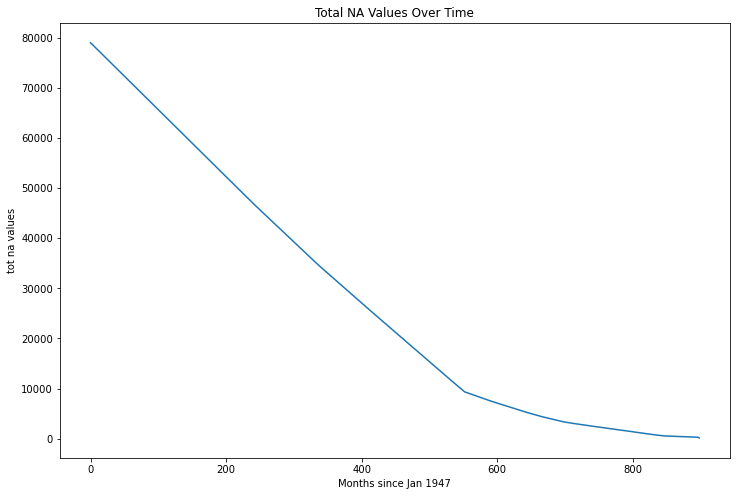

In [88]:
# Plot seeing how the total number of na values differs after x amount of months
plt.figure(figsize=[12, 8]);
sns.lineplot( x=list(range(899)), y=na_values);
plt.ylabel("tot na values");
plt.xlabel("Months since Jan 1947");
plt.title("Total NA Values Over Time");

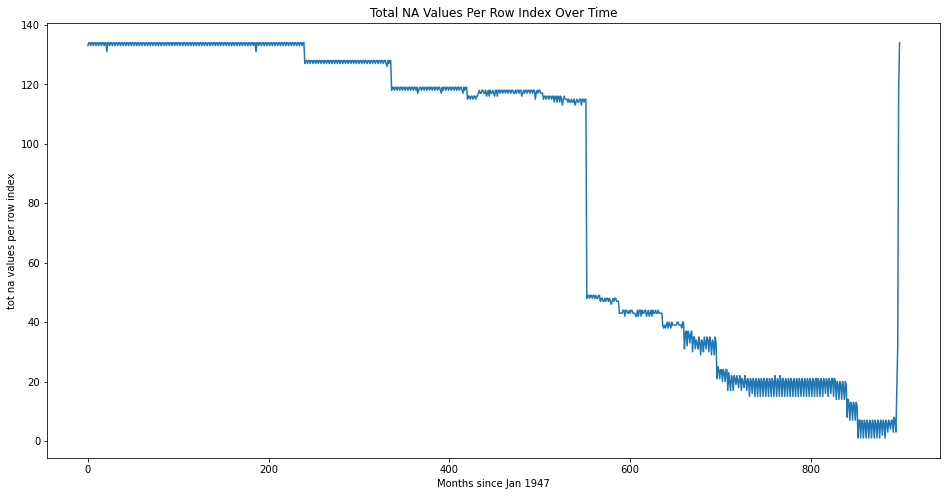

In [89]:
# Number of na columns per row index
plt.figure(figsize=[16, 8]);
sns.lineplot( x=list(range(899)), y=na_per_row);
plt.ylabel("tot na values per row index");
plt.xlabel("Months since Jan 1947");
plt.title("Total NA Values Per Row Index Over Time");

#### RELEVANCE TO RESEARCH QUESTION:

As can be seen from both graphs, there are an unacceptable amount of na values in our dataset further back in time towards 1947. This impacts our research question because without enough data, variance can have more of a spurious impact on our findings on the causal effect of infrastructure investment on utilization. These graphs, however, show that the number of na values in the dataset decrease significantly at around 550 months after January 1947, which provides a temporal scope from which to define our research question. So long as we stay within this temporal scope, we should have enough valid data to more accurately define the causal effect we are studying.

We handled null values by replacing them with 0. Most of the dataset's null values are from times when that information was not being recorded yet, so the presence of null data does not seem to correlated with anything other than time. The 0s and their impact on our model will be handled later.

In [90]:
# Replacing na values with 0 in the infrastructure dataframe
infra = infra.fillna(0)

### 2.1.3. Investigating Spending Complexity Across Infrastructure Categories

From the organized variables, we created a dictionary of infrastructure categories paired with the number of spending (investment) categories that fell under them. This metric is important to our research question because it gives a rough idea of the complexity of investment behind each category of infrastructure. Since office space has relatively few forms of spending compared to automobile-related infrastructure, for example, we will know that attempting to investigate the causal impact of automobile infrastructure on utilization will necessitate a study of many forms of automobile investment first.

In [91]:
category = []
for spending in spendings:
    if spending in waste_cleaning:
        category.append('waste_cleaning')
    elif spending in water_drinking:
        category.append('water_drinking')
    elif spending in roads:
        category.append('roads')
    elif spending in ships:
        category.append('ships')
    elif spending in air:
        category.append('air')
    elif spending in recreation:
        category.append('recreation')
    elif spending in safety:
        category.append('saftey')
    elif spending in education:
        category.append('education')
    elif spending in health:
        category.append('health')
    elif spending in business:
        category.append('business')
    elif spending in residential:
        category.append('residential')
    elif spending in rail:
        category.append('rail')
    else:
        print(spending)
        category.append('other')

State and Local Government Construction Spending - Total


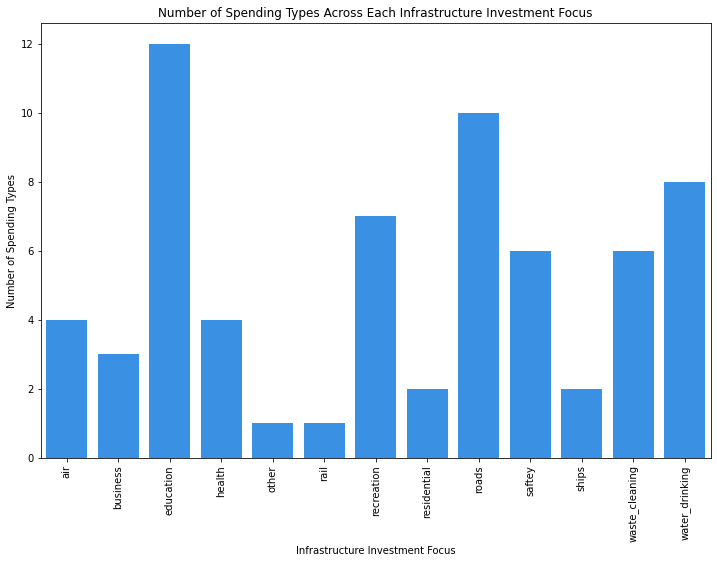

In [92]:
data = {'Number of Spending Types':spendings,
        'Infrastructure Investment Focus':category}

categories = df = pd.DataFrame(data);
categories_grouped = categories.groupby(['Infrastructure Investment Focus']).count().reset_index();
plt.figure(figsize=[12, 8]);
sns.barplot(x="Infrastructure Investment Focus", y="Number of Spending Types", data=categories_grouped, color="dodgerblue");
plt.title("Number of Spending Types Across Each Infrastructure Investment Focus");
plt.xticks(rotation=90);

#### Quantitative Variable: Number of Spending Types

#### Categorical Variable: Infrastructure Investment Focus

#### TRENDS AND RELEVANCE TO RESEARCH QUESTION:

In order to test if investment spending has a causal effect on utility, we need to figure out how we are measuring spending. By looking at the different columns we can see we have a lot of different columns of varying areas of spending. Since many of the spendings are very similar (ie elementary school spending and primary/secondary school spending), we decided it be best to group spendings into buckets. This also helps us since unlike spendings, there aren't nearly as many utility measuring columns that we can used. Furthermore, there are more NaN values present in the utility columns compared to the spending columns. Therefore, we thought that it might be a good idea to try to match up similar spendings with their respective utility groups and figure out which spending and utility pairs have the most amount of data that we could work with to figure out a causal effect.

By grouping into buckets we can reach the graph above. We notice that there not each bucket has varying levels spendings columns in it. We can see that education has a lot of spending related columns. While choosing education for our causal effect test might seem like a good choice, sadly there are not related utilty data that we can use. However, utility data on transportation related spendings such as air, roads and more are present in the dataset. We can see that especially for roads, we also have a good amount of spendings data related to it as well.

### 2.1.4. Investigating Investment-Utilization Correlations Across Different Categories of Infrastructure

To avoid repeating work, we establish a helper function that takes in an investment variable, a utilization variable, and a dataframe, and plots a scatterplot of the variables as well as printing the correlation coefficient.

#### DATA CLEANING:

Because we replaced null values with 0, including these points in our scatterplots will create clusters of points along each axis at 0, so to preserve the integrity of the scatterplot our plotting function will check if the product of each point is 0 (if either x or y is 0), and will not plot the point in the scatterplot if so. This data cleaning step within our plotting function has the effect of only plotting points for which we have data on both the investment variable and the utilization variable, thus creating scatterplots and correlation coefficients that capture the actual relationship between investment and utilization.

In [93]:
# Creating a helper function to visualize the relationship between different
# investment and utilization variables
def scatter_wline(x, y, data):
    """x: name of the investment-related variable
       y: name of the utilization-realted variable
       data: dataframe to query from"""
    
    # Defining the data
    xs = np.array(data[x])
    ys = np.array(data[y])
    
    # Remove datapoints for which value is 0 (we have no data)
    bad_points = []
    for i in range(len(data)):
        if xs[i] * ys[i] == 0:
            bad_points.append(i)
    xs = np.delete(xs, bad_points)
    ys = np.delete(ys, bad_points)    
    
    # Best fit line and correlation calculation
    m, b = np.polyfit(xs, ys, 1)
    corr = np.corrcoef(xs, ys)[0][1]
    print("Correlation: " + str(corr))
    
    # Plotting 
    plt.figure(figsize=[8,8])
    plt.scatter(xs, ys)
    plt.plot(xs, m*xs + int(b))
    plt.title(x + "\n vs\n " + y)
    plt.xlabel(x)
    plt.ylabel(y)

Plotting the investment-utilization relationship for Highway Infrastructure

Correlation: 0.48426365059771764


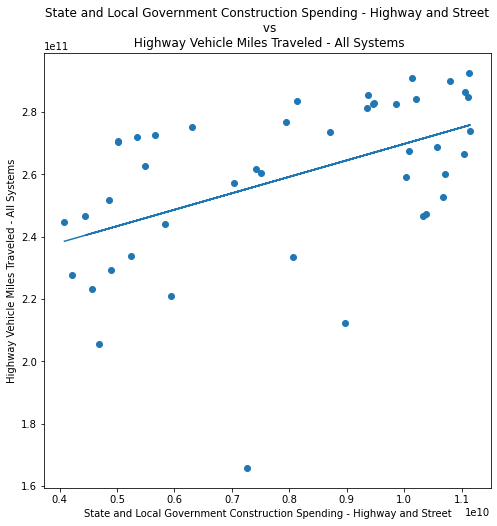

In [94]:
scatter_wline("State and Local Government Construction Spending - Highway and Street",
              "Highway Vehicle Miles Traveled - All Systems",
              infra)

#### Quantitative Variable: State and Local Government Construction Spending - Highway and Street 
#### Quantitative Variable: Highway Vehicle Miles Traveled - All Systems

Plotting the investment-utilization relationship for Air Infrastructure

Correlation: -0.4477082308908731


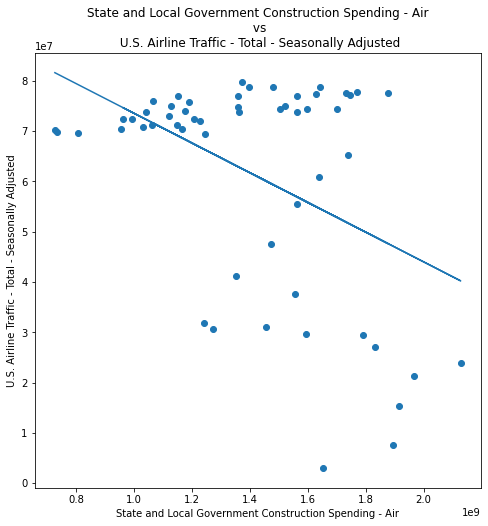

In [95]:
scatter_wline('State and Local Government Construction Spending - Air',
              'U.S. Airline Traffic - Total - Seasonally Adjusted',
              infra)

#### Quantitative Variable: State and Local Government Construction Spending - Air
#### Quantitative Variable: U.S. Airline Traffic - Total - Seasonally Adjusted

Plotting the investment-utilization relationship for Land (Rail) Infrastructure

Correlation: 0.48019054721057974


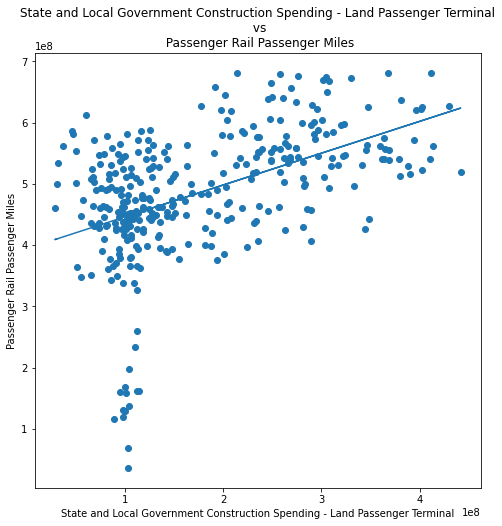

In [96]:
scatter_wline('State and Local Government Construction Spending - Land Passenger Terminal',
              'Passenger Rail Passenger Miles',
              infra)

#### Quantitative Variable: State and Local Government Construction Spending - Land
#### Quantitative Variable: Passenger Rail Total Train Miles

Plotting the investment-utilization relationship for Water Infrastructure

Correlation: 0.30844874356426427


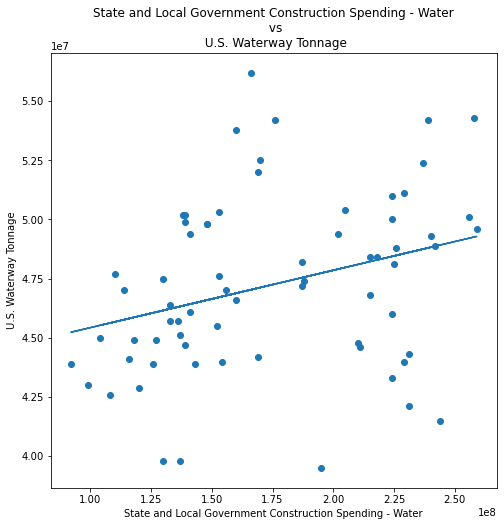

In [97]:
scatter_wline('State and Local Government Construction Spending - Water',
              'U.S. Waterway Tonnage',
              infra)

#### Quantitative Variable: State and Local Government Construction Spending - Water
#### Quantitative Variable: U.S. Waterway Tonnage

Compiling these relationships from all infrastructure categories (for which we had both investment and utilization variables anyway) into a dictionary for reference.

In [98]:
# Recording the correlation between investment and utilization for each infrastruture type
corrs_by_infra_type = {"Air": -0.4477082308908731, "Land": 0.48019054721057974, 
                       "Water": 0.30844874356426427, "Highway": 0.48426365059771764}

Creating a bar plot of the correlations to show which categories of infrascture exhibit the strongest relationships between investment and spending.

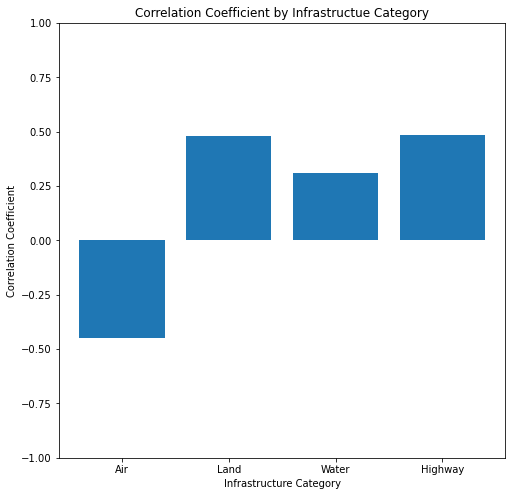

In [99]:
plt.figure(figsize=[8,8]);
plt.bar(corrs_by_infra_type.keys(),corrs_by_infra_type.values());
plt.ylabel("Correlation Coefficient");
plt.xlabel("Infrastructure Category");
plt.ylim(top=1, bottom=-1);
plt.title("Correlation Coefficient by Infrastructue Category");

#### Quantitative Variable: Investment-Utilization Correlation Coe
#### Categorical Variable: Infrastructure Category

**TRENDS AND RELEVANCE:**

There appears to be some correlation (0.31) between water investment and utilization, with an even stronger 0.48 correlation between highway investment and utilization. Though just correlation, these relationships indicate that there could be a causal effect of investment on utilization across the infrastructure categories of water and highway, which means that for our research question we will likely focus on these particular types of infrastructure for answers beyond association.<br />

In addition, there appears to be a noticable negative correlation (-0.45) between air infrastructure investment and utilization, which is unexpected since one would think that investing more in air infrastructure would increase its utilization. Not only does this mean there could be a causal effect of investment on utilization in air infrastructure too (and that we will study it), it also opens up a new question of why more air investment seems to be associated with less air utilization.<br />

These contradicting correlation coefficients across several infrastructure categories mean that the causal effect of infrastructure investment on utilization is not the same for every type of infrastructure. If anything, this means the answer to our original research question is more complex than we thought, so these opposite correlations motivate the search for the true causal effect even more.

## 2.2. EDA After Knowing Research Question

In [100]:
# ReLoading the instrastructure dataset as a Pandas dataframe
infra = pd.read_csv("Monthly_Transportation_Statistics.csv")

### 2.2.1. Dataframe Modification

Adding the treatment variable (whether State and Local Government Construction Spending - Land Passenger Terminal has increased or decreased) as an indicator (integer)

In [101]:
# Creating a binary column in our infrastructure dataframe that specifies whether
# State and Local Government Construction Spending - Land Passenger Terminal has increased or decreased
# from the previous month

# Treatment Assignment:
# * current month value - last month value > 0 --> 1
# * current month value - last month value <= 0 --> 0
# * if current month value is nan --> 0
# * if current month value is not nan and last month value is nan --> 1

treatment = list(infra['State and Local Government Construction Spending - Land Passenger Terminal'])
binary = [] # 
first_val = 0

# 0 means no treatment, 1 means with treatment
for val in range(len(treatment)):
    if math.isnan(treatment[val]):
        binary.append(0)
    elif math.isnan(treatment[val - 1]):
        first_val = val
        binary.append(1)
    elif treatment[val] - treatment[val - 1] > 0:
        binary.append(1)
    elif treatment[val] - treatment[val - 1] <= 0:
        binary.append(0)
    else:
        binary.append(0)
        
# print(first_val)
# print(len(binary))
infra['treatment'] = binary

Adding a month column

In [102]:
# Creating a month column in the infrastructure df
mod_to_month = {0: "Jan", 1: "Feb", 2: "Mar", 3: "Apr", 4:  "May", 5:  "Jun", 
                6: "Jul", 7: "Aug", 8: "Sep", 9: "Oct", 10: "Nov", 11: "Dec"}

infra["month"] = [mod_to_month[idx] for idx in (np.array(range(-1, 898)) % 12)]
month = infra["month"]

Seeing how much land passenger terminal spending (treatment) data there is to work with

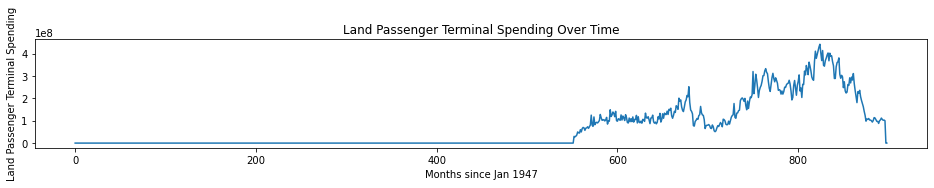

In [103]:
# Initial plot of land passenger terminal spending over time
# This shows us how much data there is to work with, as we replaced null values with 0

land_spending = infra["State and Local Government Construction Spending - Land Passenger Terminal"].fillna(0);
plt.figure(figsize=[16, 2]);
sns.lineplot( x=list(range(899)), y=land_spending);
plt.ylabel("Land Passenger Terminal Spending");
plt.xlabel("Months since Jan 1947");
plt.title("Land Passenger Terminal Spending Over Time");

Seeing how much passenger rail passenger miles (outcome) data there is to work with

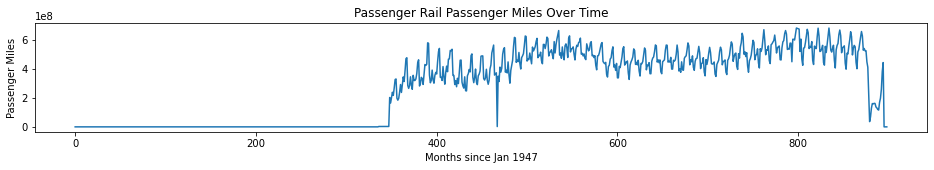

In [104]:
# Initial plot of passenger rail passenger miles over time
# This shows us how much data there is to work with, as we replaced null values with 0

passenger_mi = infra["Passenger Rail Passenger Miles"].fillna(0);
plt.figure(figsize=[16, 2]);
sns.lineplot( x=list(range(899)), y=passenger_mi);
plt.ylabel("Passenger Miles");
plt.xlabel("Months since Jan 1947");
plt.title("Passenger Rail Passenger Miles Over Time");

**Data Cleaning** <br />

As seen in the plots from the methods section, null values are overwhelmingly present in earlier sections of the infrastructure dataset chronologically. This suggests missing data is due to a lack of collection at the time and is not correlated with another variable that we are not accounting for. <br />

This means for the sake of our study, it is acceptable to handle null values by simply ignoring them, narrowing down the scope of our study to time periods when both the treatment variable, outcome variable, and confounding variable are nonnull in the dataframe. This is a filtering process we execute in the code cell below.

In [105]:
# Narrowing down the dataframe to records where all variables are nonna
infra = infra[(infra["State and Local Government Construction Spending - Land Passenger Terminal"].isna() == False) &
              (infra["Passenger Rail Passenger Miles"].isna() == False)]

## 2.3. Identifying Confounders and Colliders

### 2.3.1. Confounder 1: Month

Visualizing effect of month on treatment

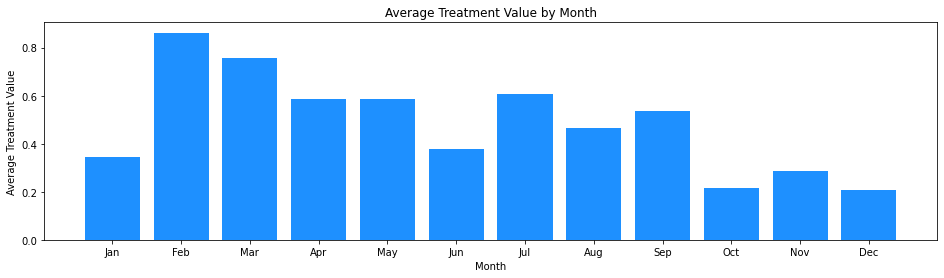

In [106]:
# Visualizing the relationship between the treatment value and month
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_avgs = []
for month in months:
    just_month = infra[infra["month"] == month]
    just_month_nonna = just_month[just_month["treatment"].isna() == False]
    month_avg = np.mean(just_month_nonna["treatment"])
    month_avgs.append(month_avg)
plt.figure(figsize=[16, 4]);
plt.bar(x=months, height=month_avgs, color="dodgerblue");
plt.title("Average Treatment Value by Month");
plt.xlabel("Month");
plt.ylabel("Average Treatment Value");

Visualizing effect of month on outcome

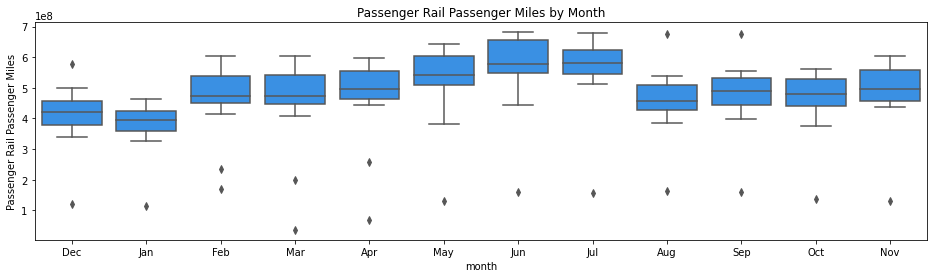

In [107]:
# Visualizing the relationship between passenger rail passenger miles and month
plt.figure(figsize=[16, 4]);
sns.boxplot(x="month", y="Passenger Rail Passenger Miles", data=infra, color="dodgerblue");
plt.title("Passenger Rail Passenger Miles by Month");

As can be seen, passenger rail passenger miles tend to be significantly greater in the Summer months from
May to July compared to the Fall and Winter months from August to January. This suggests that the time of year
does in fact influence railway utilization, the outcome variable

### 2.3.2. Confounder 2: Amtrak On-Time Performance

Checking how much non-null Amtrak on-time performance data there is to work with

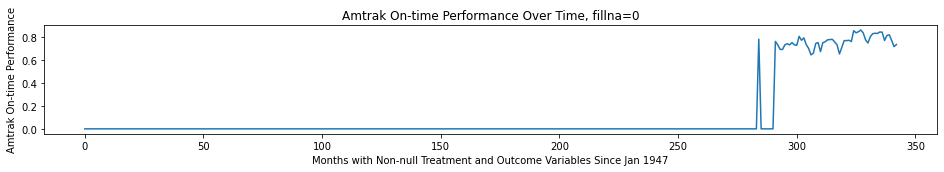

In [108]:
# Initial plot of passenger rail passenger miles over time
# This shows us how much data there is to work with, as we replaced null values with 0

amtrak_ontime = infra["Amtrak On-time Performance"].fillna(0);
plt.figure(figsize=[16, 2]);
sns.lineplot( x=list(range(len(infra))), y=amtrak_ontime);
plt.ylabel("Amtrak On-time Performance");
plt.xlabel("Months with Non-null Treatment and Outcome Variables Since Jan 1947");
plt.title("Amtrak On-time Performance Over Time, fillna=0");

Unfortunately, there is not enough data on amtrak on-time performance to integrate it into our causal study, as there appears to be only 50 records that have nonnull values. Therefore, since month data is present in every record of our infrastructure dataframe, we will use that alone as our confounder in the study.

There exists very little Amtrak on-time performance data, so we will create a sub-dataframe with non-null Amtrak on-time performance records to peform further visualizations from.

In [109]:
# Creating a sub-dataframe in which Amtrak On-time performance is nonnull
infra1 = infra[infra["Amtrak On-time Performance"].isna() == False]
infra1 = infra1[(infra1["State and Local Government Construction Spending - Land Passenger Terminal"].isna() == False) &
                (infra1["Passenger Rail Passenger Miles"].isna() == False)]

Visualizing the effect of Amtrak on-time performance on the treatment variable

In [110]:
# Visualizing the relationship between Amtrak on-time performance and the treatment variable
performances = []
# Grouping Amtrak on-time performance values into discrete bins
for performance in infra1["Amtrak On-time Performance"]:
    group = ""
    if performance < 0.70:
        group = "< 0.70"
    elif performance >= 0.70 and performance < 0.75:
        group = "0.70-75"
    elif performance >= 0.75 and performance < 0.80:
        group = "0.75-80"
    elif performance >= 0.80 and performance < 0.85:
        group = "0.80-85"
    elif performance >= 0.85:
        group = "> 0.85"
    else:
        print("fixme!")
    performances.append(group)
infra1["Amtrak On-time Group"] = performances

In [111]:
performance_groups = ["< 0.70","0.70-75","0.75-80","0.80-85","> 0.85"]

In [112]:
# Obtaining the average treatment value for each Amtrak on-time performance bin
group_avgs = []
for group in performance_groups:
    just_group = infra1[infra1["Amtrak On-time Group"] == group]
    group_avg = np.mean(just_group["treatment"])
    group_avgs.append(group_avg)

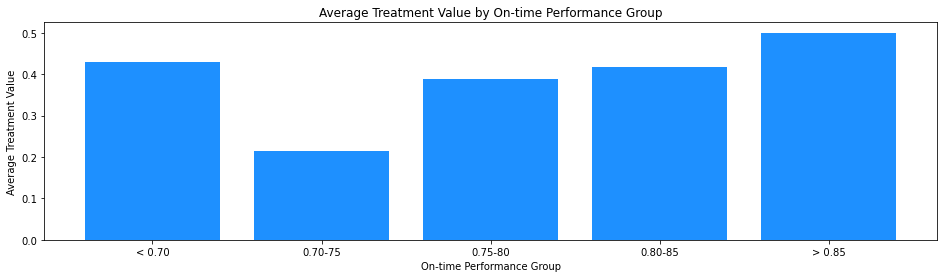

In [113]:
# Visualizing the result as a bar plot
plt.figure(figsize=[16, 4]);
plt.bar(x=performance_groups, height=group_avgs, color="dodgerblue");
plt.title("Average Treatment Value by On-time Performance Group");
plt.xlabel("On-time Performance Group");
plt.ylabel("Average Treatment Value");

Visualizing the effect of Amtrak on-time performance on the outcome variable

Correlation: -0.742079297053696


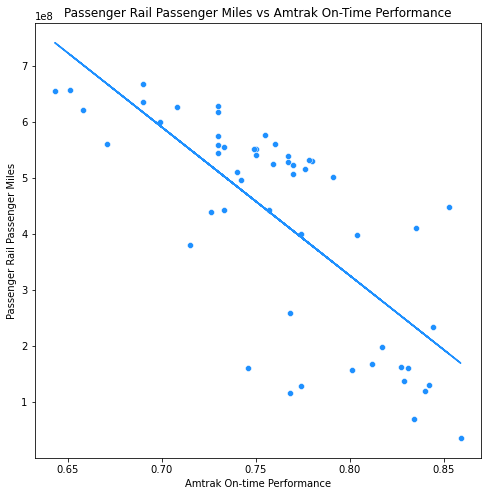

In [114]:
# Visualizing the relationship between gov spending on land passenger terminals and amtrak on-time performance
plt.figure(figsize=[8, 8]);
xs = np.array(infra1["Amtrak On-time Performance"])
ys = np.array(infra1["Passenger Rail Passenger Miles"])
sns.scatterplot(x="Amtrak On-time Performance", y="Passenger Rail Passenger Miles", data=infra1,
            color="dodgerblue");
# Best fit line and correlation calculation
m, b = np.polyfit(xs, ys, 1)
corr = np.corrcoef(xs, ys)[0][1]
plt.plot(xs, m*xs + int(b), color="dodgerblue")
print("Correlation: " + str(corr))
plt.ylabel("Passenger Rail Passenger Miles");
plt.title("Passenger Rail Passenger Miles vs Amtrak On-Time Performance");

### 2.3.3. Collider 1: Rail Employment

Visualizing the effect of the treatment variable on rail employment

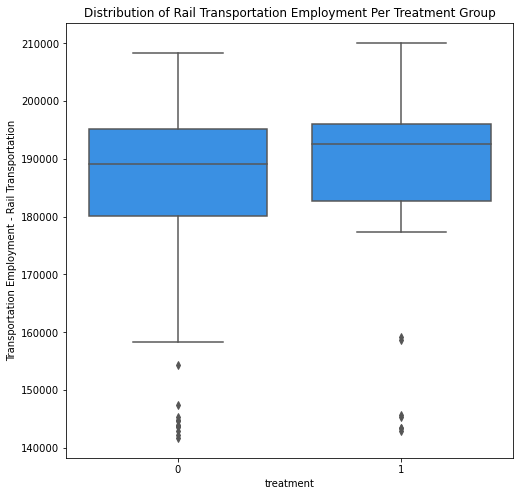

In [115]:
# Visualizing the relationship between the treatment variable and rail employment
plt.figure(figsize=[8, 8]);
sns.boxplot(x="treatment",y="Transportation Employment - Rail Transportation", data=infra, color="dodgerblue");
plt.title("Distribution of Rail Transportation Employment Per Treatment Group");

Visualizing the relationship between the outcome variable and rail employment

Correlation: 0.8604921782253068


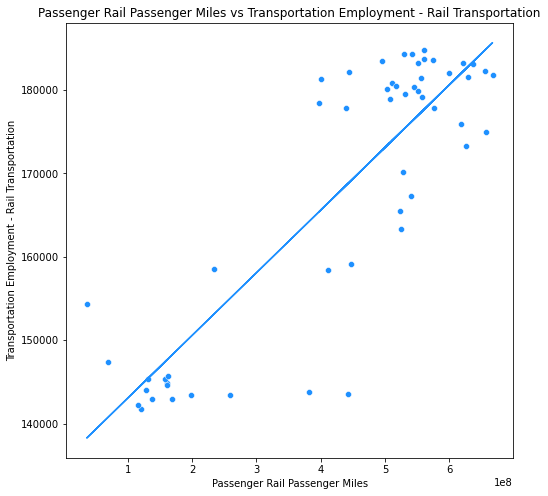

In [116]:
# Visualizing the relationship between passenger rail passenger miles and rail employment
plt.figure(figsize=[8, 8]);
xs = np.array(infra1["Passenger Rail Passenger Miles"])
ys = np.array(infra1["Transportation Employment - Rail Transportation"])
sns.scatterplot(x="Passenger Rail Passenger Miles", y="Transportation Employment - Rail Transportation", data=infra1,
            color="dodgerblue");
# Best fit line and correlation calculation
m, b = np.polyfit(xs, ys, 1)
corr = np.corrcoef(xs, ys)[0][1]
plt.plot(xs, m*xs + int(b), color="dodgerblue")
print("Correlation: " + str(corr))
plt.ylabel("Transportation Employment - Rail Transportation");
plt.title("Passenger Rail Passenger Miles vs Transportation Employment - Rail Transportation");

## 2.4. Methods

### 2.4.1. Treatment and Outcome Variables

**Describe which variables correspond to treatment and outcome.**

### Treatment: Direction of Change in State and Local Gov Construction Spending - Land Passenger Terminal from Previous Month

Explanation: <br />

Government spending on land passenger terminals is the treatment variable because spending money on constructing land terminals constitutes an investment in the future use of said terminals by trains. This variable, therefore, is a measure of infrastructure investment.

Specifically, we wish to see if the *change* in government spending on land passenger terminals has a causal effect on railway utilization, so we take a further step to define the treatment variable as whether government spending on land passenger terminals increases from the previous month (Z=1) or decreases from the previous month (Z=0).

### 2.4.2.  Outcome: Passenger Rail Passenger Miles

Explanation: <br />

Passenger rail passenger miles represent the movement of 1 passenger for 1 mile, meaning they reflect both the volume of passengers that travel by rail as well as the cumulative distance by rail travelled. This variable, therefore, constitutes a relatively comprehensive measure of railway utilization, which is what we wish to investigate the causal effect of railway investment on.

## 2.5. Confounders

**Describe which variables (if any) are confounders. If the unconfoundedness assumption
holds, make a convincing argument for why.**

### 2.5.1. Confounder 1: Month

Explanation: <br />

Month is a confounder because seasonal travel increases rail demand, prompting the government to spend more on infrastructure in advance and driving increases in passenger mileage during holidays.

As can be seen, passenger rail passenger miles tend to be significantly greater in the Summer months from
May to July compared to the Fall and Winter months from August to January. This suggests that the time of year
does in fact influence railway utilization, the outcome variable

Average treatment value reflects how often the treatment was 1 relative to how often it was 0, this bar plot shows treatment tends to be true in the late Winter and early Spring months compared to other times of the year. This suggests that the time of year does in fact influence railway investment, the treatment variable. Because month affects both treatment and outcome, it is thus a confounding variable we must control for before inferring any causal effects of treatment on outcome.

### 2.5.2. Confounder 2: Amtrak On-Time Performance

Explanation: <br />

Amtrak OTP is a confounder because deteriorating rail efficiency prompts improvement through increased government construction and disincentivizes rail travel for travellers, decreasing passenger mileage.

### Unconfoundeness Assumption:

The unconfoundedness assumption that all confounding variables are observed and can be controlled for does not hold because we lack enough data on the confounding variable of Amtrak OTP to properly observe and control for it. 


## 2.6. Handling Confounders

**What methods will you use to adjust for confounders?**

To handle the confounder of month, we will use matching since month is categorical and has only 12 possible values, creating ample opportunities to match treatment-outcome pairs on it. In addition, this is an observational study, so we have no randomization to eliminate the confounding influence of month. Matching is useful for situations like this because it eliminates the confounding influence by conditioning on it instead.

## 2.7. Colliders

Are there any colliders in the dataset?

Rail transportation employment is a collider in this dataset because spending more on LPT construction necessitates more rail transportation staff to maintain them, and the volume of rail passengers as measured through PRPM also necessitates a corresponding amount of rail employees to meet demand. Thus, we will avoid conditioning on this collider in the study.


## 2.8. Setup Summary

In [134]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://github.com/alexmcui/main-sharing/blob/master/rail_causal_dag.png?raw=true")

## 2.9 Supporting Work

**Matching**

Sorting data to aid matching later on

In [118]:
# Splitting the cleaned infrastructure dataframe into sub-dataframes that each share the same month
january = infra[infra["month"] == "Jan"]
february = infra[infra["month"] == "Feb"]
march = infra[infra["month"] == "Mar"]
april = infra[infra["month"] == "Apr"]
may = infra[infra["month"] == "May"]
june = infra[infra["month"] == "Jun"]
july = infra[infra["month"] == "Jul"]
august = infra[infra["month"] == "Aug"]
september = infra[infra["month"] == "Sep"]
october = infra[infra["month"] == "Oct"]
november = infra[infra["month"] == "Nov"]
december = infra[infra["month"] == "Dec"]

months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
month_to_int = {"Jan":1,"Feb":2,"Mar":3,"Apr":4,"May":5,"Jun":6,"Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12}
month_to_df = {"Jan":january,"Feb":february,"Mar":march,"Apr":april,"May":may,"Jun":june,
               "Jul":july,"Aug":august,"Sep":september,"Oct":october,"Nov":november,"Dec":december}
month_dfs = [january, february, march, april, may, june, july, 
             august, september, october, november, december] 

In [119]:
# Creating a helper function that takes in a dataframe that has been conditioned on month
# and assigns pairs between outcome variables that did have treatment and that didn't,
# returning an array of their differences
def match(df, seed):
    """Input: df: a dataframe of infrastructure data conditioned on month
       Output: an array of differences between outcome variables
               that did have treatment and that didn't"""
    diffs = []
    outcomes_with_treatment = list(df[df["treatment"] == 1]["Passenger Rail Passenger Miles"])
    outcomes_without_treatment = list(df[df["treatment"] == 0]["Passenger Rail Passenger Miles"])
    
    # Setting shuffle seed to ensure reproducibility
    random.seed(seed)
    random.shuffle(outcomes_with_treatment)
    random.shuffle(outcomes_without_treatment)
    
    num_pairs = min(len(outcomes_with_treatment), len(outcomes_without_treatment))
    for i in range(num_pairs):
        diffs.append(outcomes_with_treatment[i] - outcomes_without_treatment[i])
    return diffs

Having conditioned the data on month in our work section, we obtain results by randomly assigning pairs of outcome variables that did have the treatment and that did not have the treatment within each month-conditioned dataframe, combining the differences in pairs conditioned on each of the 12 months to create a total list of differences, which we average to obtain our estimate of the average treatment effect (ATE) of increasing government spending on land passenger terminals on passenger rail passenger miles.

In [120]:
all_diffs = []
# For each month, pair outcome variables where Z=1 and Z=0 and append their differences to the total diff array
for month in months:
    # Random seed step to ensure reproducibility
    seed = month_to_int[month]+11
    # Obtain the month_filtered df for that month and match on it
    month_df = month_to_df[month]
    all_diffs += match(month_df, seed)
ate = np.mean(all_diffs)
print("ATE estimate: " + str(ate))

ATE estimate: 23490115.663716815


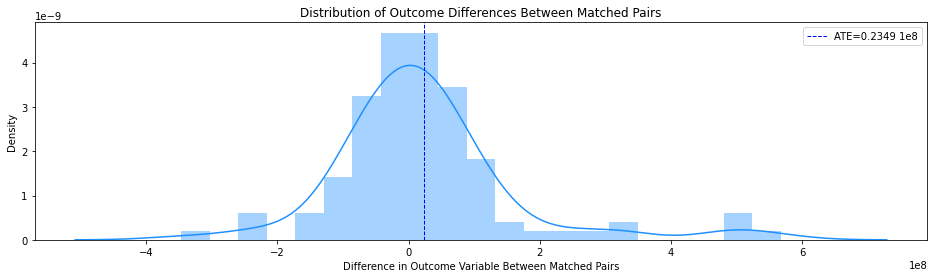

In [121]:
# Plotting the distribution of matched pair differences
plt.figure(figsize=[16, 4]);
sns.distplot(all_diffs, color="dodgerblue");
plt.axvline(ate, color='b', linestyle='dashed', linewidth=1, label=("ATE=" + str(np.round(ate/100000000,5))+" 1e8"));
plt.legend();
plt.xlabel("Difference in Outcome Variable Between Matched Pairs");
plt.title("Distribution of Outcome Differences Between Matched Pairs");

In [122]:
# Helper function that takes any sample, matches records based on month, 
# and returns the ATE of that sample
def match_and_ATE(sample, seed):
    jan_ = sample[sample["month"] == "Jan"]
    feb_ = sample[sample["month"] == "Feb"]
    mar_ = sample[sample["month"] == "Mar"]
    apr_ = sample[sample["month"] == "Apr"]
    may_ = sample[sample["month"] == "May"]
    jun_ = sample[sample["month"] == "Jun"]
    jul_ = sample[sample["month"] == "Jul"]
    aug_ = sample[sample["month"] == "Aug"]
    sep_ = sample[sample["month"] == "Sep"]
    oct_ = sample[sample["month"] == "Oct"]
    nov_ = sample[sample["month"] == "Nov"]
    dec_ = sample[sample["month"] == "Dec"]
    month_dfs = [jan_, feb_, mar_, apr_, may_, jun_, jul_, 
             aug_, sep_, oct_, nov_, dec_] 
    all_diffs = []
    for month in month_dfs:
        seed += 1
        all_diffs += match(month, seed)
        ate = np.mean(all_diffs)
    return ate  

In [123]:
# Bootstrapping rows of the original dataset
sample_size = 34
repetitions = 10000
ates = []
for repetition in range(repetitions):
    if repetition%1000 == 0:
        progress = (repetition/repetitions)*100
        print("Bootstrap " + str(progress)+"% done")
    sample = infra.sample(n=sample_size,replace=True,random_state=repetition)
    # Seed for reproducibility
    seed = repetition*12
    ate = match_and_ATE(sample, seed)
    ates.append(ate)
print("Bootstrap 100.0% done")
ates = np.array(ates)
ates_var_boot = np.var(ates)

Bootstrap 0.0% done
Bootstrap 10.0% done
Bootstrap 20.0% done
Bootstrap 30.0% done
Bootstrap 40.0% done
Bootstrap 50.0% done
Bootstrap 60.0% done
Bootstrap 70.0% done
Bootstrap 80.0% done
Bootstrap 90.0% done
Bootstrap 100.0% done


In [124]:
# Removing null values from the bootstrapped ATES array by replacing them with 0
ates = np.nan_to_num(ates)
ates

array([ 1.07009759e+08,  1.06601000e+06,  2.14144884e+07, ...,
        5.01165365e+07,  5.70226065e+07, -4.19010657e+07])

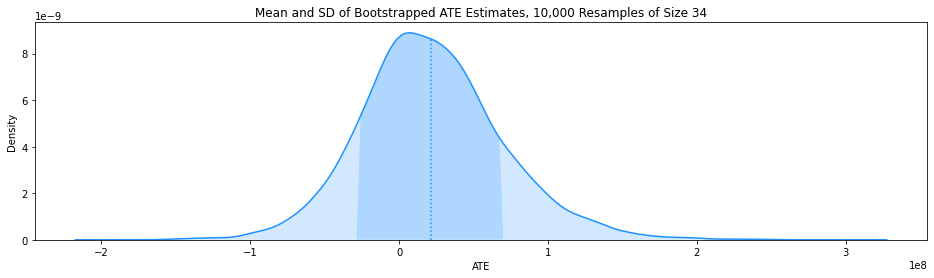

In [125]:
# Plotting the distribution of bootstrapped ATEs, focusing on mean and sd
fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
sns.kdeplot(ates, shade=False, color='dodgerblue', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
middle = ates.mean()
std = ates.std()
left = middle - std
right = middle + std
ax.set_title('Mean and SD of Bootstrapped ATE Estimates, 10,000 Resamples of Size 34')
ax.set_xlabel("ATE")
ax.vlines(middle, 0, np.interp(middle, xs, ys), color='dodgerblue', ls=':')
ax.fill_between(xs, 0, ys, facecolor='dodgerblue', alpha=0.2)
ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='dodgerblue', alpha=0.2)
plt.show()

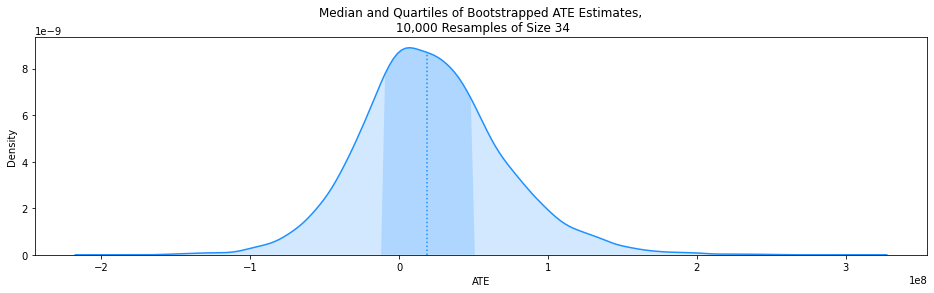

In [126]:
# Plotting the distribution of bootstrapped ATEs, focusing on median and quartiles
fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
sns.kdeplot(ates, shade=False, color='dodgerblue', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
left, middle, right = np.percentile(ates, [25, 50, 75])
ax.set_title('Median and Quartiles of Bootstrapped ATE Estimates,\n 10,000 Resamples of Size 34')
ax.set_xlabel("ATE")
ax.vlines(middle, 0, np.interp(middle, xs, ys), color='dodgerblue', ls=':')
ax.fill_between(xs, 0, ys, facecolor='dodgerblue', alpha=0.2)
ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='dodgerblue', alpha=0.2)
plt.show()

In [127]:
# Calculating the variance of the bootstrapped ATEs
ates_var_boot = np.var(ates)
print("Bootstrapped ATE variance: " + str(ates_var_boot))

Bootstrapped ATE variance: 2319458933764664.5


In [128]:
# Calculating the standard deviation of the bootstrapped ATEs
ates_sd_boot = np.sqrt(ates_var_boot)
print("Bootstrapped ATE standard deviation: " + str(ates_sd_boot))

Bootstrapped ATE standard deviation: 48160761.34951216


In [129]:
# Calculating the standard error of the bootstrapped ATEs
n = len(ates)
sme = ates_sd_boot/(np.sqrt(n))
print("Bootstrapped ATE standard error of mean: " + str(sme))

Bootstrapped ATE standard error of mean: 481607.6134951216


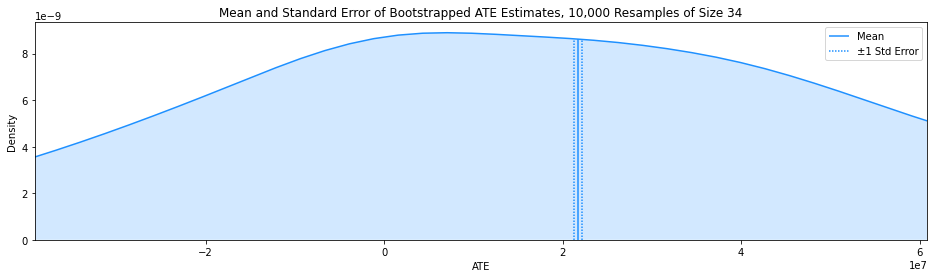

In [130]:
# Plotting the distribution of bootstrapped ATEs, focusing on standard error
fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
sns.kdeplot(ates, shade=False, color='dodgerblue', ax=ax)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
middle = ates.mean()
std = ates.std()
n = len(ates)
sme = std/(np.sqrt(n))
left = middle - sme
right = middle + sme
ax.set_title('Mean and Standard Error of Bootstrapped ATE Estimates, 10,000 Resamples of Size 34')
ax.set_xlabel("ATE")
ax.vlines(middle, 0, np.interp(middle, xs, ys), color='dodgerblue', ls='solid', label="Mean")
#
ax.vlines(left, 0, np.interp(left, xs, ys), color='dodgerblue', ls=(0,(1,1)), label="±1 Std Error")
ax.vlines(right, 0, np.interp(right, xs, ys), color='dodgerblue', ls=(0,(1,1)))
#
ax.fill_between(xs, 0, ys, facecolor='dodgerblue', alpha=0.2)
#ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='dodgerblue', alpha=0.2)
sorta_middle = int(middle)/2
plt.xlim([sorta_middle-50000000, sorta_middle+50000000])
plt.legend()
plt.show()

**Interpret your results, providing a clear statement about causality (or a
lack thereof) including any assumptions necessary.**

Assuming month is the only confounding variable at play (since it is the only one our results are conditioned on), we found the ATE estimate from matching is 23.4901 million. The interpretation of this estimate is that increasing state and local government construction spending on land PRPM causes an increase of 23.4901 million PRPM in a given month, on average. This effect, although subtle, is positive, meaning these results support a positive causal effect of the treatment on the outcome.


**Where possible, discuss the uncertainty in your estimate and/or the evidence against the
hypotheses you are investigating.**

This estimate is not without flaws. We performed bootstrapping by resampling records (sample size=34) from the original data to recompute ATE 10,000 times. The bootstrap ATE variance is 2.319 1e16, meaning standard deviation is 4.816 1e7 and standard error is 4.816 1e5. This quantification means the bootstrapped ATE mean is likely very close to the true one, as visualized in figure 16, suggesting ATE is in fact positive on average. An ATE of 0, however, is within one standard deviation of the bootstrapped ATE mean, meaning the causal effect we discovered could still be negative with a non-negligible probability depending on the sample matches, making this positive effect a barely-perceptible one. Our estimate is also imperfect because our assumption that month is the only confounding variable does not hold. We could not control for the other confounding variable of Amtrak OTP because it was non-null in only 50 records, so its confounding influence on both rail investment and utilization is not reflected in our ATE estimate.


## 2.10 Discussion

**Elaborate on the limitations of your methods.**

Our method of turning rail infrastructure investment into a binary variable was a limiting choice because it does not capture the magnitude of investment but rather whether it soley increased or decreased from the previous month. For example, what if rail infrastructure increased by 100% vs 1%? Treatment would still be true either way in our study, meaning the causal effect of an increase in rail infrastructure on utilization that we found is not as descriptive as we would have hoped. While we would have performed a causal study investigating the causal effect of rail infrastructure investment itself (as a continuous variable) on railway utilization using 2SLS regression, this would have required the identification of an instrumental variable, which we did not have in our dataset.

**What additional data would be useful for answering this causal question, and why?**

Having Amtrak on-time performance data from further back in time would have been helpful because we would have been able to condition on it as a confounding variable in our study. This means our ATE estimate would correctly factor in the confounding influence of all confounders in the infrastructure dataset and thus produce an ATE estimate closer to the true casual effect of an increase in rail infrastructure investment on utilization.

**How confident are you that there’s a causal relationship between your chosen treatment
and outcome? Why?**

We believe there exists some relationship between whether the government increases spending on LPTs and how much passengers utilize rail transportation. EDA showed a positive correlation (0.48) between construction spending on LPTs and PRPM, for instance, and the ATE of increasing LPT spending from the previous month is an increase of 23.490 million PRPM. We are, however, uncertain about our specific ATE estimate. The ATE can also be negative within one SD as found via bootstrapping, for instance, which is only countered by the fact that our standard error for the bootstrapped ATE is so low (482K PRPM). We also did not account for the influence of Amtrak OTP, but that influence would have to be around as great as the observed ATE to negate that causal effect from the rail investment alone. Nevertheless, this means our ATE estimate is likely different from the true ATE of increasing railway spending on rail utilization.